In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud, ImageColorGenerator
pd.options.plotting.backend = 'plotly'
from PIL import Image as Img

%config InlineBackend.figure_format = 'retina'

In [2]:
fonts = ['../Netflix_fonts/']
for font in fm.findSystemFonts(fonts):
    fm.fontManager.addfont(font)

In [3]:
netflix_df = pd.read_csv('netflix_titles.csv')
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


# High Level Summary

- Data Features

	- 8807 total records in the dataset
	- 12 different columns - we focused primarily on 4 columns of interest
		- Type (Movie or TV Show)
		- Country (Location the Movie/Show was produced) - Total number of unique countries - 122
		- Date Added (When Netflix added the title to their library) - primary focus on years 2015-2021
		- Listed In (Category/Genre of Movie/TV Show)
			- International, Drama, Comedy were highest performers across all categories
	- External Data
		- Netflix Revenue and Income during years from data set


## Goal

- Identify trends in content added to the Netflix Platform that fostered growth and allowed the company to capitalize on towards global expansion in the years following 2015

In [5]:
netflix_df['type'].astype('category')
netflix_df['rating'].astype('category')

0       PG-13
1       TV-MA
2       TV-MA
3       TV-MA
4       TV-MA
        ...  
8802        R
8803    TV-Y7
8804        R
8805       PG
8806    TV-14
Name: rating, Length: 8807, dtype: category
Categories (17, object): ['66 min', '74 min', '84 min', 'G', ..., 'TV-Y', 'TV-Y7', 'TV-Y7-FV', 'UR']

In [6]:
inacc_ratings = netflix_df[netflix_df['rating'] == '74 min'].copy()
inacc_ratings

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."


In [7]:
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'])

In [8]:
netflix_df['date_added'].unique()

array(['2021-09-25T00:00:00.000000000', '2021-09-24T00:00:00.000000000',
       '2021-09-23T00:00:00.000000000', ...,
       '2018-12-06T00:00:00.000000000', '2016-03-09T00:00:00.000000000',
       '2020-01-11T00:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
netflix_df['year_added'] = netflix_df['date_added'].dt.year
netflix_df['year_added'].unique()

array([2021., 2020., 2019., 2018., 2017., 2016., 2015., 2014., 2013.,
       2012., 2011., 2009., 2008.,   nan, 2010.])

In [10]:
netflix_df['month_added'] = netflix_df['date_added'].dt.month_name()
netflix_df['month_added'].unique()

netflix_df['month_added'] = netflix_df['month_added'].replace(np.nan, 'Missing')

In [11]:
final_month = netflix_df.groupby(['month_added', 'year_added', 'type']).count()['show_id']
print(final_month)

month_added  year_added  type   
April        2014.0      Movie        1
                         TV Show      1
             2015.0      Movie        1
                         TV Show      4
             2016.0      Movie       14
                                   ... 
September    2019.0      TV Show     37
             2020.0      Movie      115
                         TV Show     53
             2021.0      Movie      118
                         TV Show     65
Name: show_id, Length: 193, dtype: int64


In [12]:
type_freq_df = netflix_df.groupby(['year_added', 'type']).count()['title']
type_freq_df = type_freq_df.to_frame()

# create separate dataframes for movies and tv shows
movies = type_freq_df[type_freq_df.index.get_level_values('type')=='Movie'].copy()
tv_shows = type_freq_df[type_freq_df.index.get_level_values('type')=='TV Show'].copy()

# get all years that movies have recorded values
mov_years = movies.index.get_level_values('year_added')
# update tv shows to have all the years with 0s
for year in mov_years:
    if year not in tv_shows.index.get_level_values('year_added'):
        pass
        tv_shows.loc[(year, 'TV Show'), 'title'] = 0
tv_shows.sort_index(inplace=True)

# calculate the total movies and tv shows added by year
freq_df = pd.concat([movies, tv_shows])
freq_df.sort_index(inplace=True)
freq_df['title'] = freq_df['title'].astype(int)
freq_df = freq_df.set_axis(['Count'], axis='columns')
year_totals = freq_df.groupby(level=0).sum()

# calculate proportions for tv shows and movies (of total additions by year)
movies['Proportion'] = movies['title'] / year_totals['Count']
tv_shows['Proportion'] = tv_shows['title'] / year_totals['Count']


In [13]:
cumulative_movies = movies.cumsum()
cumulative_movies = cumulative_movies.droplevel(1)
#cumulative_movies = cumulative_movies.drop('Proportion', axis=1)
print(cumulative_movies)

cumulative_tv = tv_shows.cumsum()
cumulative_tv = cumulative_tv.droplevel(1)
#cumulative_tv = cumulative_tv.drop('Proportion', axis=1)
cumulative_tv

            title  Proportion
year_added                   
2008.0          1    0.500000
2009.0          3    1.500000
2010.0          4    2.500000
2011.0         17    3.500000
2012.0         20    4.500000
2013.0         26    5.045455
2014.0         45    5.837121
2015.0        101    6.520048
2016.0        354    7.109792
2017.0       1193    7.816021
2018.0       2430    8.566172
2019.0       3854    9.272521
2020.0       5138    9.955864
2021.0       6131   10.618747


,title,Proportion
year_added,,
2008.0,1.0,0.500000
2009.0,1.0,0.500000
2010.0,1.0,0.500000
2011.0,1.0,0.500000
2012.0,1.0,0.500000
2013.0,6.0,0.954545
2014.0,11.0,1.162879
2015.0,37.0,1.479952
2016.0,213.0,1.890208


In [14]:
'''test_fig, ax = plt.subplots(figsize=(10,6))

ax.plot(cum_movies.index, cum_movies.values, color='#db0000')
ax.plot(cum_tv.index, cum_tv.values, color='#564d4d')

ax.text(2021.1, 6100, s='Movies', color='#db0000', weight='bold', size=12)
ax.text(2021.1, 2675, s='TV Shows', color='#564d4d', weight='bold', size=12)

ax.set_xticks(np.arange(2008, 2022), [str(i) for i in range(2008, 2022)])

ax.set_title('Cumulative Totals - Movies and TV Shows', size=18, weight='bold')
ax.set_xlabel('Year', size=16)
ax.set_ylabel('Total Content', size=16)
ax.spines[['top', 'right']].set_visible(False)
plt.show()'''

"test_fig, ax = plt.subplots(figsize=(10,6))\n\nax.plot(cum_movies.index, cum_movies.values, color='#db0000')\nax.plot(cum_tv.index, cum_tv.values, color='#564d4d')\n\nax.text(2021.1, 6100, s='Movies', color='#db0000', weight='bold', size=12)\nax.text(2021.1, 2675, s='TV Shows', color='#564d4d', weight='bold', size=12)\n\nax.set_xticks(np.arange(2008, 2022), [str(i) for i in range(2008, 2022)])\n\nax.set_title('Cumulative Totals - Movies and TV Shows', size=18, weight='bold')\nax.set_xlabel('Year', size=16)\nax.set_ylabel('Total Content', size=16)\nax.spines[['top', 'right']].set_visible(False)\nplt.show()"

In [15]:
netflix_df['listed_in'] = netflix_df['listed_in'].str.lower()
netflix_df['listed_in'] = netflix_df['listed_in'].str.strip()
type_text = netflix_df['listed_in'].str.cat(sep=',')
stopwords = ['movies', 'tv', 'shows']

In [16]:
mask = np.array(Img.open('Netflix_Symbol_RGB.png'))

def color_func(*args, **kargs):
	country_dict = {'united':'#db0000', 'states':'#db0000', 'spain':'#db0000', 'kingdom':'#db0000',
					'japan':'#db0000', 'france':'#000000', 'south':'#000000', 'china':'#000000', 'mexico':'#000000',
					'nigeria':'#000000', 'indonesia':'#000000'}
	if args[0] in country_dict.keys():
		return country_dict[args[0]]
	else:
		return '#831010'

# Word Clouds to offer Insights for text-based columns

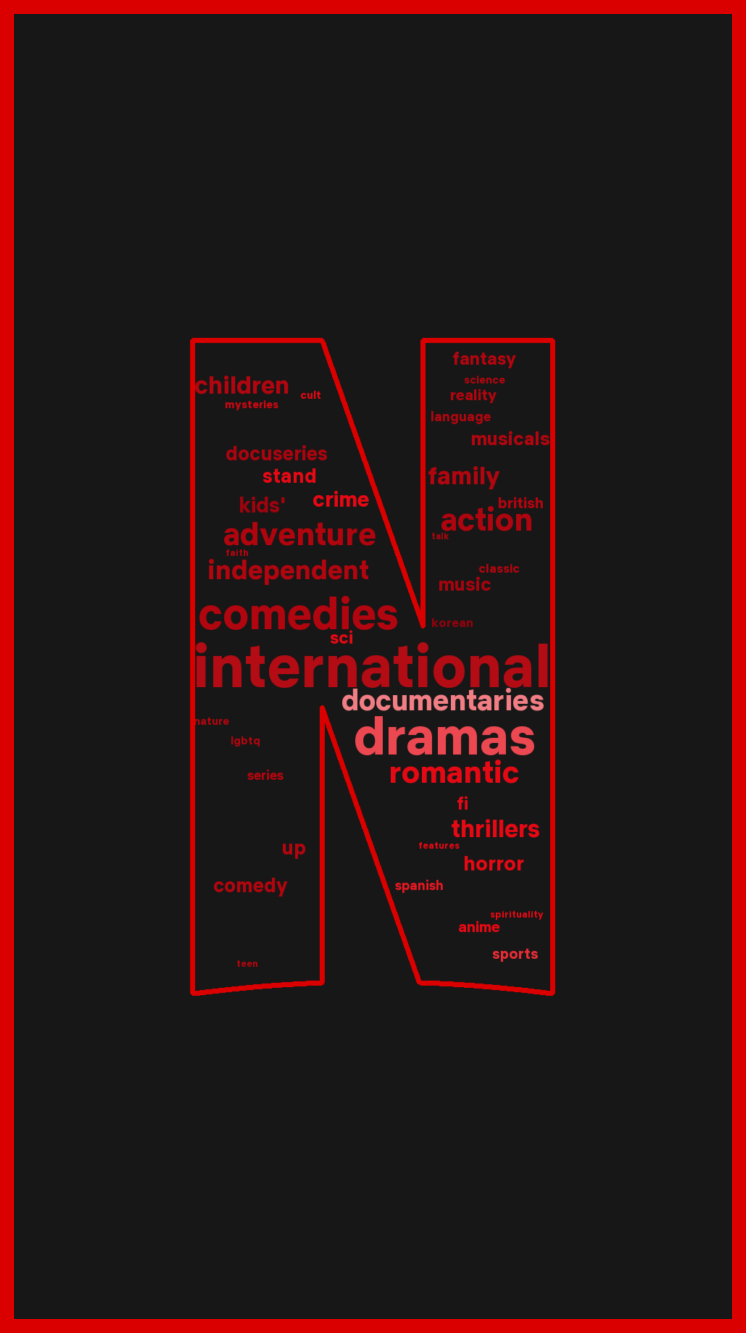

In [17]:
wordcloud = WordCloud(background_color='#181717', max_words=90, mode='RGB', collocations=False,
                      mask=mask, max_font_size=700, width=mask.shape[1], height=mask.shape[0],
                      contour_color='#db0000', contour_width=10, color_func=color_func, min_font_size=0, prefer_horizontal=1,
                      stopwords=stopwords, font_path='/Users/colinbennie/MSDS_BootCamp/EDA_msds593/Netflix_fonts/NetflixSans-Bold.ttf')
wordcloud.generate(type_text)

im_colors = ImageColorGenerator(mask)
wordcloud.recolor(color_func=im_colors)
plt.figure(figsize=(20,12), facecolor='#db0000')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

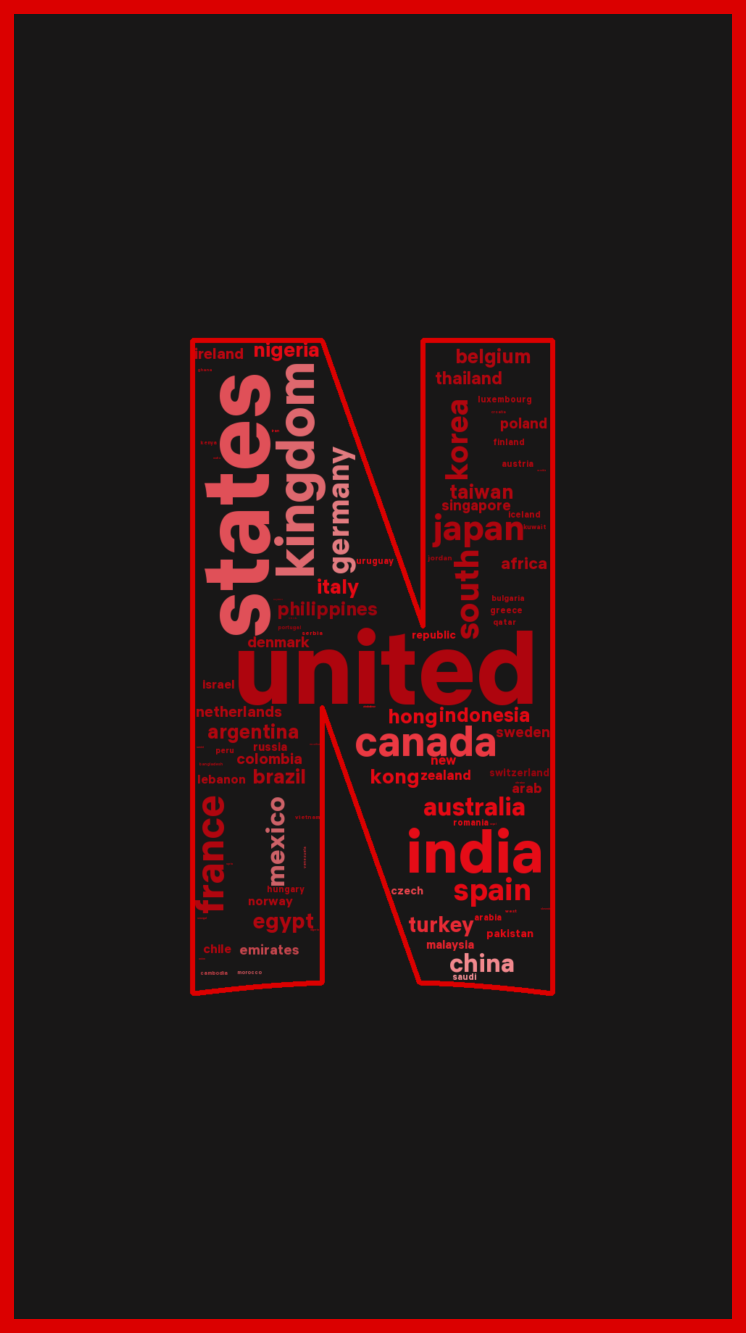

In [18]:
netflix_df['countries'] = netflix_df['country'].str.lower()
netflix_df['countries'] = netflix_df['countries'].str.strip()
country_text = netflix_df['countries'].str.cat(sep=',')
mask = np.array(Img.open('Netflix_Symbol_RGB.png'))

def color_func(*args, **kargs):
	country_dict = {'united':'#db0000', 'states':'#db0000', 'spain':'#db0000', 'kingdom':'#db0000',
					'japan':'#db0000', 'france':'#000000', 'south':'#000000', 'china':'#000000', 'mexico':'#000000',
					'nigeria':'#000000', 'indonesia':'#000000'}
	if args[0] in country_dict.keys():
		return country_dict[args[0]]
	else:
		return '#831010'

wordcloud = WordCloud(background_color='#181717', max_words=90, mode='RGB', collocations=False,
                      mask=mask, max_font_size=700, width=mask.shape[1]-300, height=mask.shape[0]-300,
                      contour_color='#db0000', contour_width=10, color_func=color_func, min_font_size=0,
					  font_path='/Users/colinbennie/MSDS_BootCamp/EDA_msds593/Netflix_fonts/NetflixSans-Bold.ttf')
im_colors = ImageColorGenerator(mask)
wordcloud.generate(country_text)
wordcloud.recolor(color_func=im_colors)
plt.figure(figsize=(20,12), facecolor='#db0000')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
type_freq_df = netflix_df.groupby(['year_added', 'type']).count()['title']
type_freq_df = type_freq_df.to_frame()

# create separate dataframes for movies and tv shows
movies = type_freq_df[type_freq_df.index.get_level_values('type')=='Movie'].copy()
tv_shows = type_freq_df[type_freq_df.index.get_level_values('type')=='TV Show'].copy()

In [20]:
netflix_df['international'] = netflix_df['listed_in'].str.contains('international')
netflix_df['documentary'] = netflix_df['listed_in'].str.contains('documentaries|docuseries')
netflix_df['drama'] = netflix_df['listed_in'].str.contains('dramas')
netflix_df['comedy'] = netflix_df['listed_in'].str.contains('comedies', 'comedy')
netflix_df['romantic'] = netflix_df['listed_in'].str.contains('romantic')
netflix_df['independent'] = netflix_df['listed_in'].str.contains('independent')
netflix_df['action-adventure'] = netflix_df['listed_in'].str.contains('action|adventure')
netflix_df['family'] = netflix_df['listed_in'].str.contains('family|children')

In [21]:
family_counts = netflix_df.groupby(['year_added', 'type'])['family'].sum()

family_tv = family_counts[family_counts.index.get_level_values('type')=='TV Show']
family_tv = family_tv.droplevel(1)

family_movies = family_counts[family_counts.index.get_level_values('type')=='Movie']
family_movies = family_movies.droplevel(1)


In [22]:
act_adv_counts = netflix_df.groupby(['year_added', 'type'])['action-adventure'].sum()

act_adv_tv = act_adv_counts[act_adv_counts.index.get_level_values('type')=='TV Show']
act_adv_tv = act_adv_tv.droplevel(1)

act_adv_movies = act_adv_counts[act_adv_counts.index.get_level_values('type')=='Movie']
act_adv_movies = act_adv_movies.droplevel(1)


In [23]:
international_counts = netflix_df.groupby(['year_added', 'type'])['international'].sum()

international_tv = international_counts[international_counts.index.get_level_values('type')=='TV Show']
international_tv = international_tv.droplevel(1)

international_movies = international_counts[international_counts.index.get_level_values('type')=='Movie']
international_movies = international_movies.droplevel(1)

In [24]:
documentary_counts = netflix_df.groupby(['year_added', 'type'])['documentary'].sum()

tv_docs = documentary_counts[documentary_counts.index.get_level_values('type')=='TV Show']
tv_docs = tv_docs.droplevel(1)

movie_docs = documentary_counts[documentary_counts.index.get_level_values('type')=='Movie']
movie_docs = movie_docs.droplevel(1)

In [25]:
drama_counts = netflix_df.groupby(['year_added', 'type'])['drama'].sum()

tv_dramas = drama_counts[drama_counts.index.get_level_values('type')=='TV Show']
tv_dramas = tv_dramas.droplevel(1)

movie_dramas = drama_counts[drama_counts.index.get_level_values('type')=='Movie']
movie_dramas = movie_dramas.droplevel(1)

In [26]:
comedy_counts = netflix_df.groupby(['year_added', 'type'])['comedy'].sum()

tv_comedy = comedy_counts[comedy_counts.index.get_level_values('type')=='TV Show']
tv_comedy = tv_comedy.droplevel(1)

comedy_movies = comedy_counts[comedy_counts.index.get_level_values('type')=='Movie']
comedy_movies = comedy_movies.droplevel(1)


In [27]:
independent_counts = netflix_df.groupby(['year_added', 'type'])['independent'].sum()

independent_tv = independent_counts[independent_counts.index.get_level_values('type')=='TV Show']
independent_tv = independent_tv.droplevel(1)

independent_movies = independent_counts[independent_counts.index.get_level_values('type')=='Movie']
independent_movies = independent_movies.droplevel(1)

In [28]:
romantic_counts = netflix_df.groupby(['year_added', 'type'])['romantic'].sum()

romantic_tv = romantic_counts[romantic_counts.index.get_level_values('type')=='TV Show']
romantic_tv = romantic_tv.droplevel(1)

romantic_movies = romantic_counts[romantic_counts.index.get_level_values('type')=='Movie']
romantic_movies = romantic_movies.droplevel(1)

In [29]:
cumulative_int_movies = international_movies.cumsum()
cumulative_drama_movies = movie_dramas.cumsum()
cumulative_documentaries = movie_docs.cumsum()
cumulative_comedy_movies = comedy_movies.cumsum()
cumulative_indie_movies = independent_movies.cumsum()
cumulative_romance_movies = romantic_movies.cumsum()
cumulative_act_adv_movies = act_adv_movies.cumsum()
cumulative_family_movies = family_movies.cumsum()

In [30]:
type_table = type_freq_df.pivot_table(index='year_added', columns='type', values='title')
#print(cumulative_int_movies)
#print(cumulative_drama_movies)
# print(cumulative_comedy_movies)
# print(type_table.cumsum())
print((cumulative_int_movies.loc[2021] - cumulative_int_movies.loc[2016])/6)
print(cumulative_int_movies.loc[2021])
print(cumulative_movies)

442.6666666666667
2752
            title  Proportion
year_added                   
2008.0          1    0.500000
2009.0          3    1.500000
2010.0          4    2.500000
2011.0         17    3.500000
2012.0         20    4.500000
2013.0         26    5.045455
2014.0         45    5.837121
2015.0        101    6.520048
2016.0        354    7.109792
2017.0       1193    7.816021
2018.0       2430    8.566172
2019.0       3854    9.272521
2020.0       5138    9.955864
2021.0       6131   10.618747


# Cumulative Total Plots For Genres

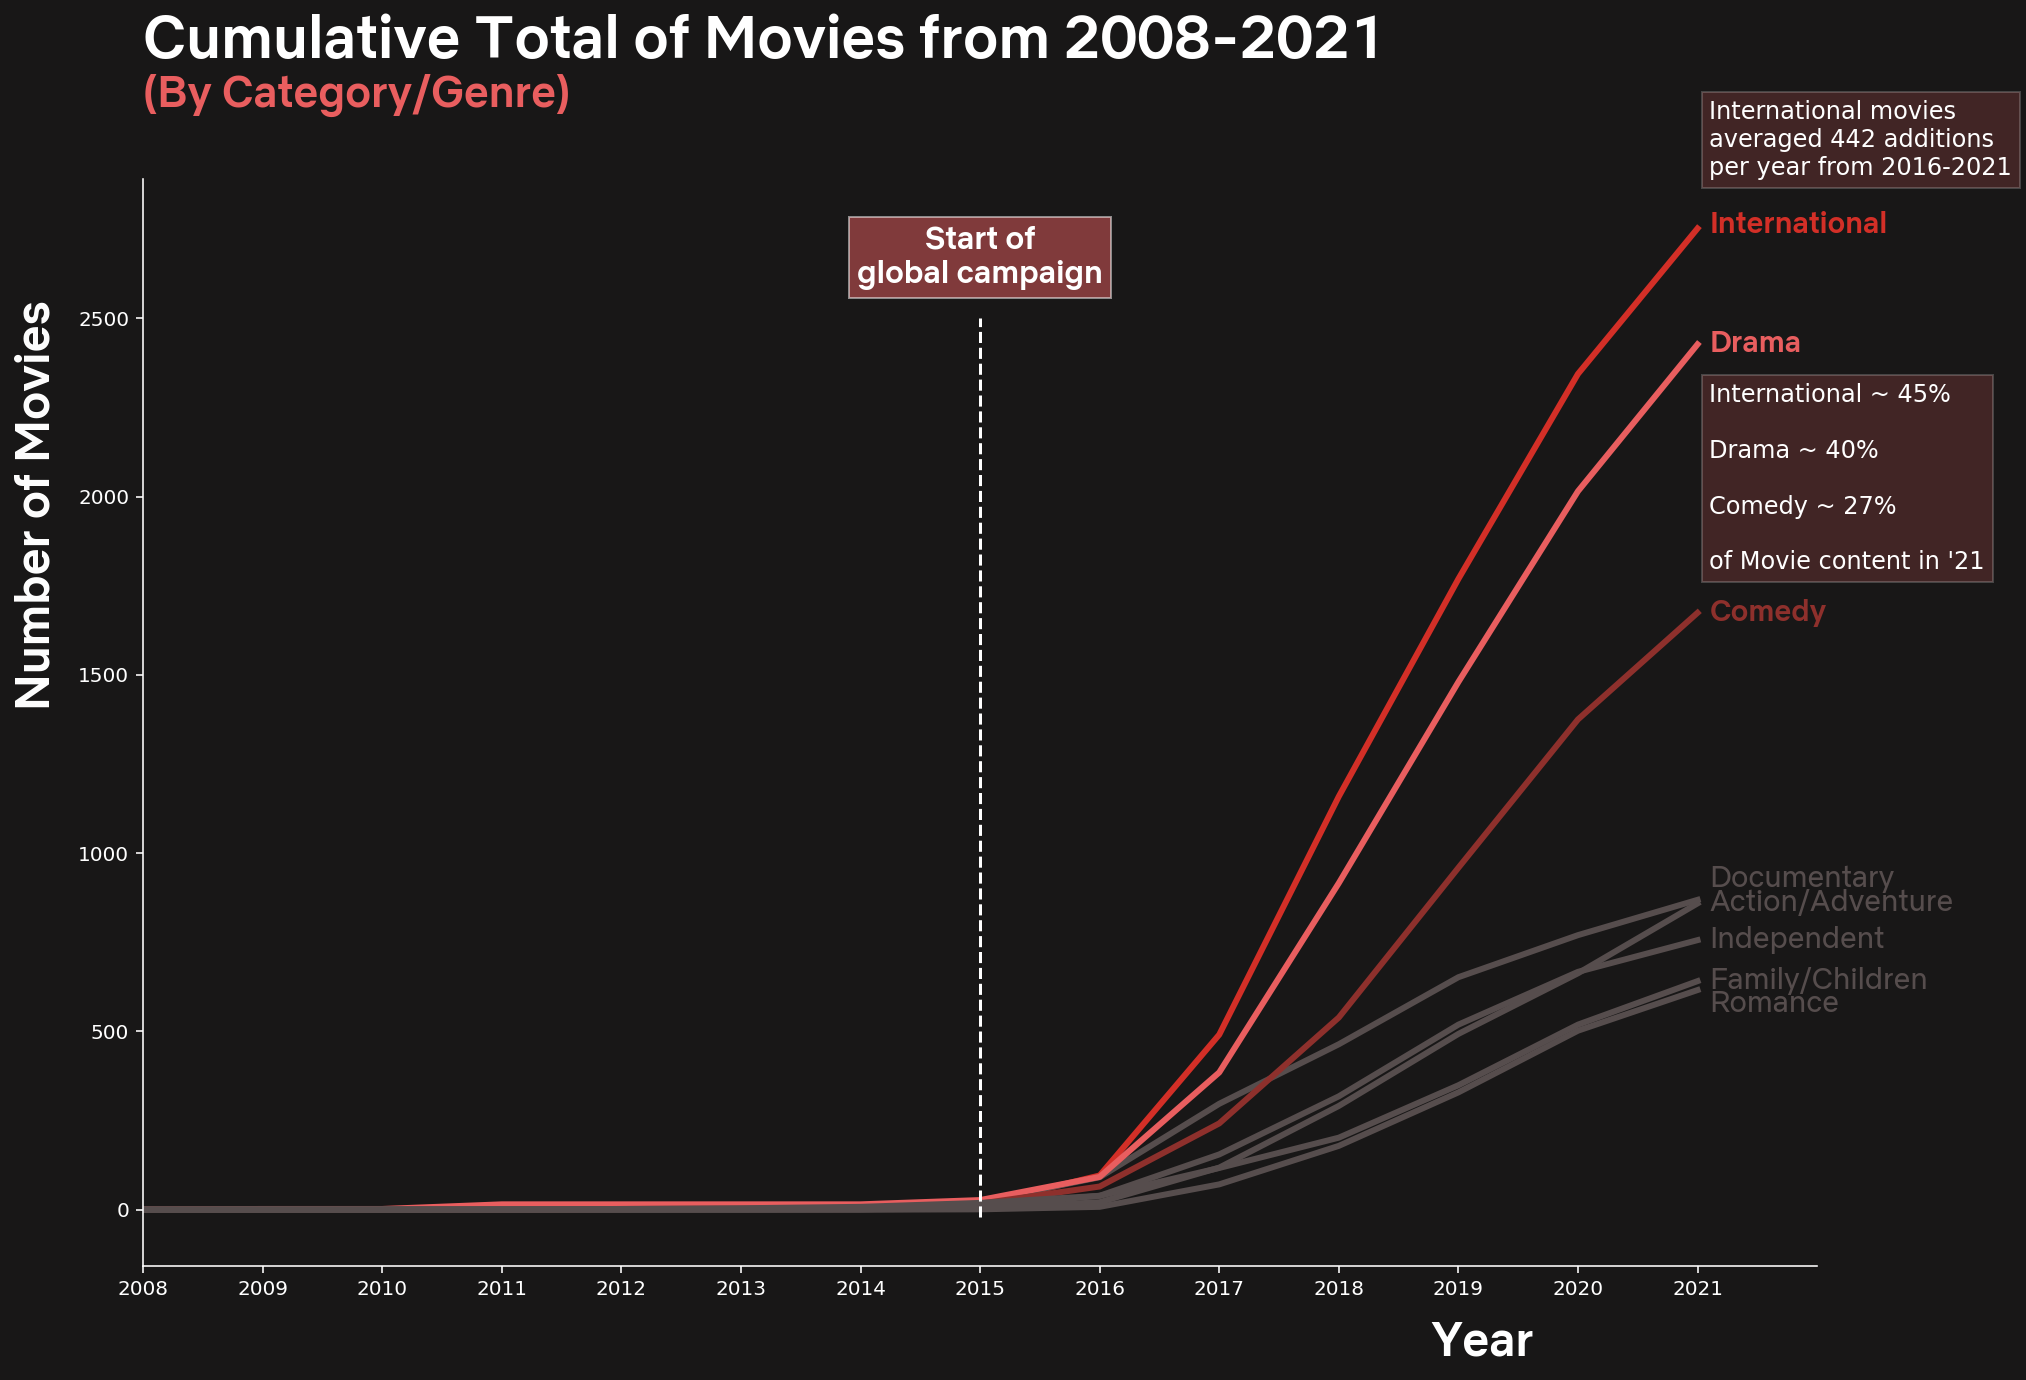

In [86]:
fig, ax = plt.subplots(figsize=(15,10))

labels = ['International', 'Documentary', 'Drama', 'Comedy', 'Independent',
          'Romance', 'Action/Adventure', 'Family/Children']

movie_colors = ['#D32F27', '#564d4d','#E95E5F', '#8E302C', '#564d4d', '#564d4d', '#564d4d','#564d4d']

movie_dfs = [cumulative_int_movies, cumulative_documentaries, cumulative_drama_movies, cumulative_comedy_movies,
          cumulative_indie_movies, cumulative_romance_movies, cumulative_act_adv_movies, cumulative_family_movies]

ax.plot(cumulative_int_movies, c=movie_colors[0], label='International', lw=3)
ax.plot(cumulative_documentaries, c=movie_colors[1], label='Documentary',lw=3)
ax.plot(cumulative_drama_movies, c=movie_colors[2], label='Drama',lw=3)
ax.plot(cumulative_comedy_movies, c=movie_colors[3], label='Comedy',lw=3)
ax.plot(cumulative_indie_movies, c=movie_colors[4], label='Independent',lw=3)
ax.plot(cumulative_romance_movies, c=movie_colors[5], label='Romantic',lw=3)
ax.plot(cumulative_act_adv_movies, c=movie_colors[6], label='Action/Adventure',lw=3)
ax.plot(cumulative_family_movies, c=movie_colors[7], label='Family/Children',lw=3)

for i in range(len(labels)):
    if i == 0:
        ax.text(2021.1, movie_dfs[i][2021.0]+10, s=labels[i], verticalalignment='center', horizontalalignment='left',
                color=movie_colors[i], fontdict=dict(fontsize=15, weight='bold', font='Netflix Sans'))
    elif i == 1:
        ax.text(2021.1, movie_dfs[i][2021.0]+60, s=labels[i], verticalalignment='center', horizontalalignment='left',
                color=movie_colors[i], fontdict=dict(fontsize=15, font='Netflix Sans'))
    elif i == 5:
        ax.text(2021.1, movie_dfs[i][2021.0]-40, s=labels[i], verticalalignment='center', horizontalalignment='left',
                color=movie_colors[i], fontdict=dict(fontsize=15, font='Netflix Sans'))
    elif (i == 2) or (i == 3):
        ax.text(2021.1, movie_dfs[i][2021.0], s=labels[i], verticalalignment='center', horizontalalignment='left',
                color=movie_colors[i], fontdict=dict(fontsize=15, weight='bold', font='Netflix Sans'))
    else:
        ax.text(2021.1, movie_dfs[i][2021.0], s=labels[i], verticalalignment='center', horizontalalignment='left',
                color=movie_colors[i], fontdict=dict(fontsize=15, font='Netflix Sans'))

ax.set_title('Cumulative Total of Movies from 2008-2021', fontdict=dict(fontsize=30, weight='bold', font='Netflix Sans', color='white'), x=0, y=1.1, horizontalalignment='left')
ax.set_xlabel('Year', fontdict=dict(fontsize=24, weight='bold', font='Netflix Sans', color='white'))
ax.set_ylabel('Number of Movies', fontdict=dict(fontsize=24, weight='bold', font='Netflix Sans', color='white'))
ax.xaxis.set_label_coords(0.8, -0.05)
ax.yaxis.set_label_coords(-0.05, 0.7)

ax.set_xlim(2013, 2022)

ax.set_xticks(np.arange(2008, 2022), [str(i) for i in np.arange(2008, 2022)])

ax.text(2008, 3125, "(By Category/Genre)", fontdict=dict(fontsize=22, weight='bold', font='Netflix Sans', 
                                                            horizontalalignment='left', verticalalignment='center', color='#E95E5F'))

ax.vlines(2015, ymin=-20, ymax=2500, colors='#ffffff',
          linestyles='dashed')

ax.text(2015, 2600, s='Start of\nglobal campaign', 
        bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.5),
        horizontalalignment='center', weight='bold', fontsize=16, font='Netflix Sans', color='white')


ax.text(2021.1, 3000, 'International movies\naveraged 442 additions\nper year from 2016-2021', bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.2),
        verticalalignment='center', horizontalalignment='left', color='white',fontsize=12)
ax.text(2021.1, 2050, "International ~ 45%\n\nDrama ~ 40%\n\nComedy ~ 27%\n\nof Movie content in '21", bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.2),
        verticalalignment='center', horizontalalignment='left', color='white', fontsize=12)

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor('#181717')
fig.set_facecolor('#181717')

plt.savefig('Cumulative_Movies.pdf')
plt.show()

In [32]:
cumulative_int_tv = international_tv.cumsum()
cumulative_drama_tv = tv_dramas.cumsum()
cumulative_documentaries_tv = tv_docs.cumsum()
cumulative_comedy_tv = tv_comedy.cumsum()
cumulative_indie_tv = independent_tv.cumsum()
cumulative_romance_tv = romantic_tv.cumsum()
cumulative_act_adv_tv = act_adv_tv.cumsum()
cumulative_family_tv = family_tv.cumsum()

In [33]:
type_table = type_freq_df.pivot_table(index='year_added', columns='type', values='title')
# print(cumulative_int_tv)
# print(cumulative_drama_tv)
# print(cumulative_comedy_tv)
# print(type_table.cumsum())

In [34]:
tv_colors = ['#D32F27', '#564d4d','#E95E5F', '#8E302C', '#564d4d', '#564d4d', '#564d4d']

tv_types = ['International', 'Documentary', 'Drama', 'Comedy', 'Independent',
            'Romance', 'Action/Adventure']

tv_dfs = [cumulative_int_tv, cumulative_documentaries_tv, cumulative_drama_tv, cumulative_comedy_tv,
          cumulative_indie_tv, cumulative_romance_tv, cumulative_act_adv_tv]

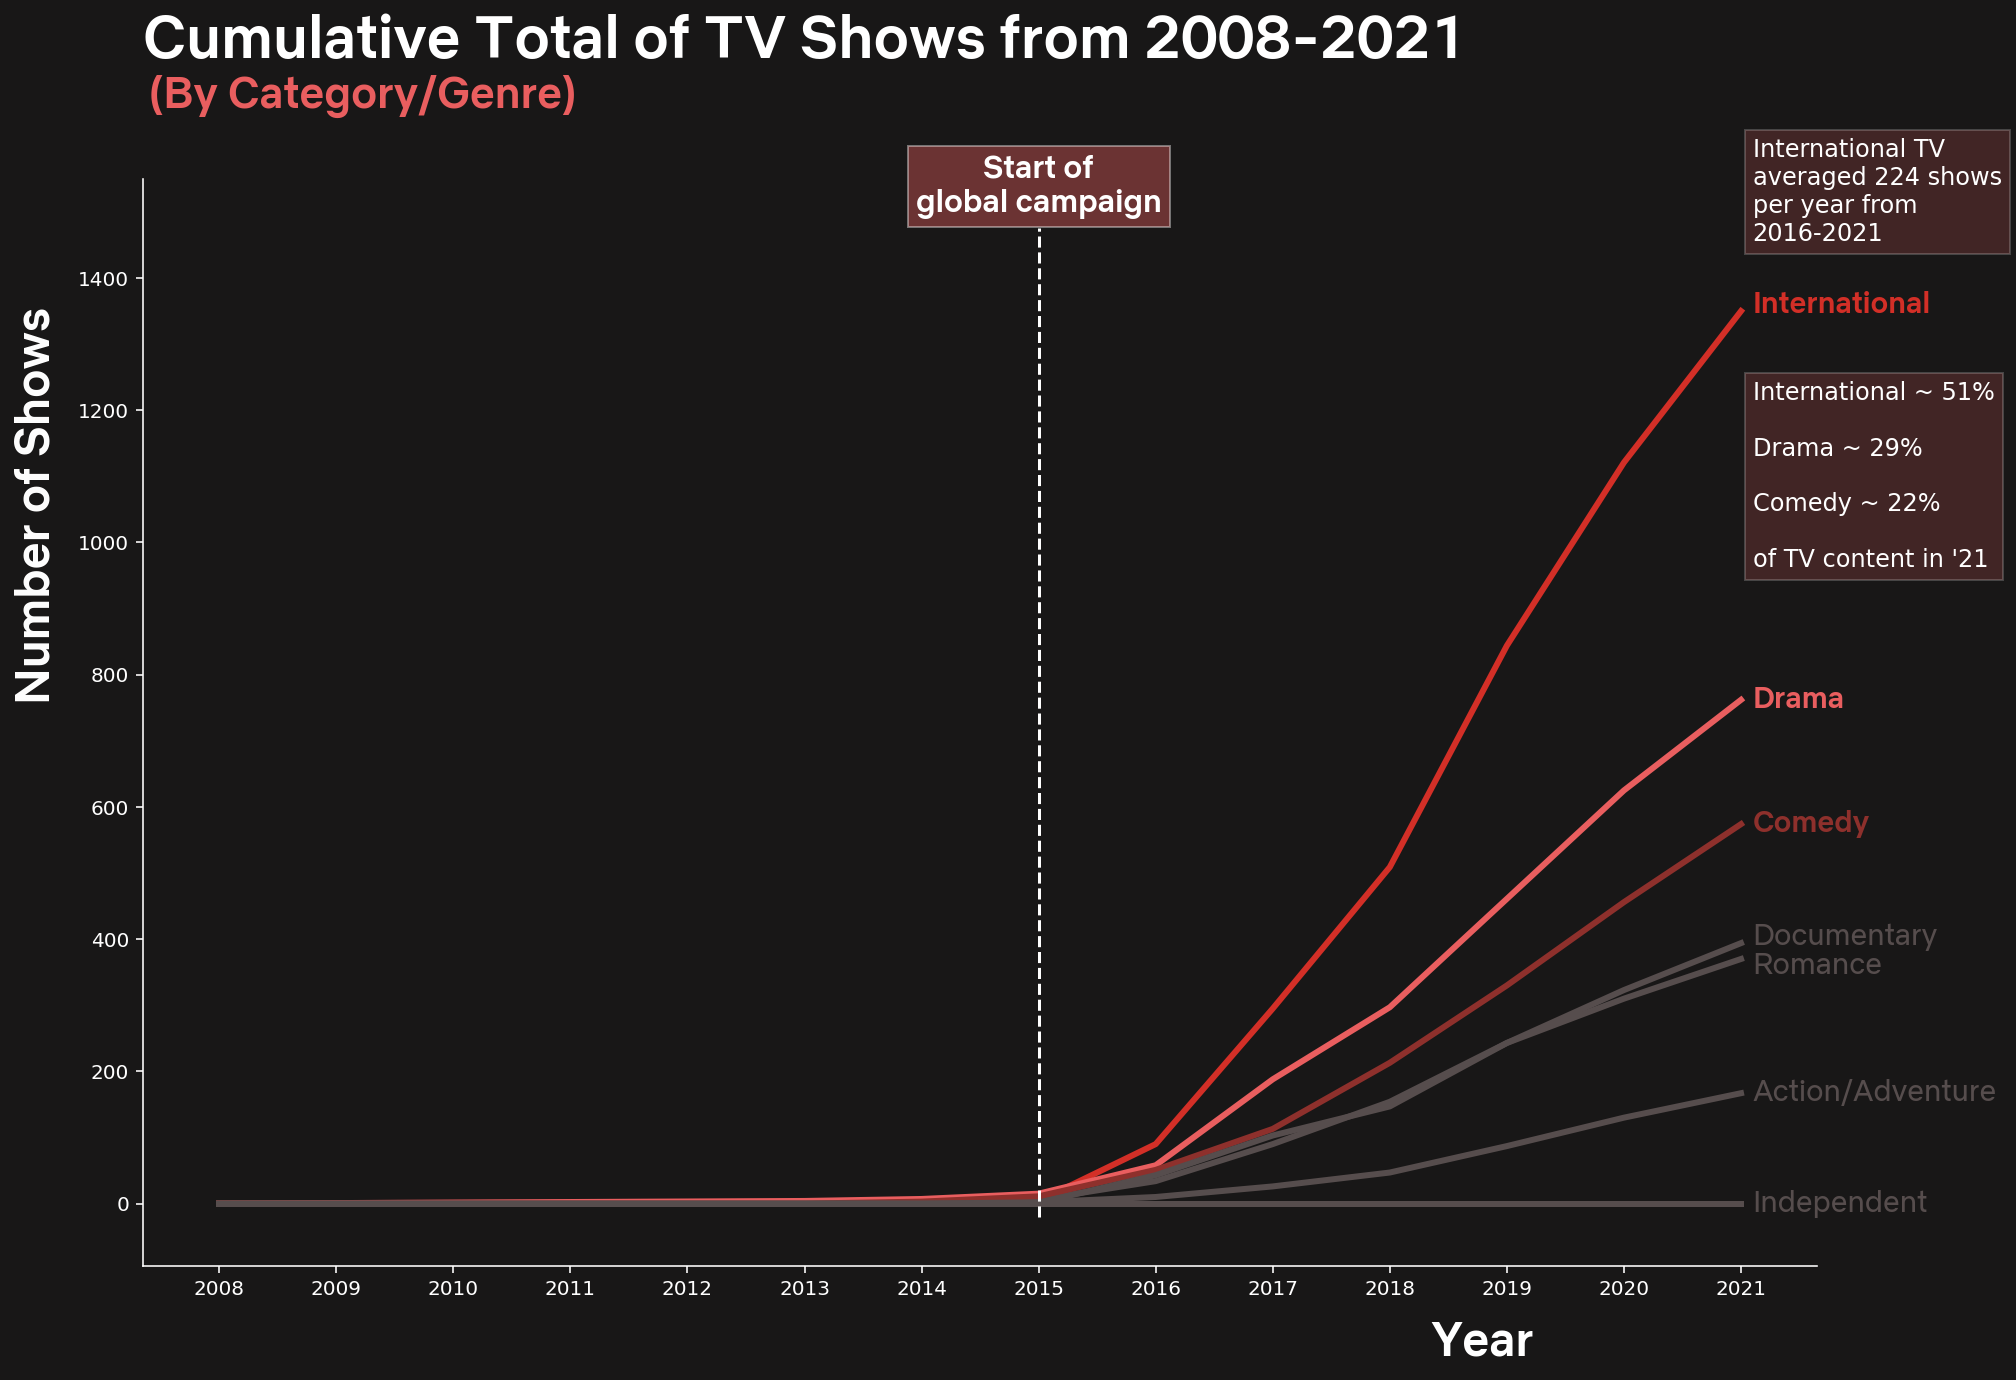

In [85]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(cumulative_int_tv, c=tv_colors[0], label='International', lw=3)
ax.plot(cumulative_documentaries_tv, c=tv_colors[1], label='Documentary', lw=3)
ax.plot(cumulative_drama_tv, c=tv_colors[2], label='Drama', lw=3)
ax.plot(cumulative_comedy_tv, c=tv_colors[3], label='Comedy', lw=3)
ax.plot(cumulative_indie_tv, c=tv_colors[4], label='Independent', lw=3)
ax.plot(cumulative_romance_tv, c=tv_colors[5], label='Romantic', lw=3)
ax.plot(cumulative_act_adv_tv, c=tv_colors[6], label='Action/Adventure', lw=3)

for i in range(len(tv_types)):
    if i == 0:
        ax.text(2021.1, tv_dfs[i][2021.0]+10, s=tv_types[i], verticalalignment='center', horizontalalignment='left',
                color=tv_colors[i], fontdict=dict(fontsize=15, weight='bold', font='Netflix Sans'))
    elif i == 1:
        ax.text(2021.1, tv_dfs[i][2021.0]+10, s=tv_types[i], verticalalignment='center', horizontalalignment='left',
                color=tv_colors[i], fontdict=dict(fontsize=15, font='Netflix Sans'))
    elif i == 5:
        ax.text(2021.1, tv_dfs[i][2021.0]-10, s=tv_types[i], verticalalignment='center', horizontalalignment='left',
                color=tv_colors[i], fontdict=dict(fontsize=15, font='Netflix Sans'))
    elif (i == 2) or (i == 3):
        ax.text(2021.1, tv_dfs[i][2021.0], s=tv_types[i], verticalalignment='center', horizontalalignment='left',
                color=tv_colors[i], fontdict=dict(fontsize=15, weight='bold', font='Netflix Sans'))
    else:
        ax.text(2021.1, tv_dfs[i][2021.0], s=tv_types[i], verticalalignment='center', horizontalalignment='left',
                color=tv_colors[i], fontdict=dict(fontsize=15, font='Netflix Sans'))

ax.set_title('Cumulative Total of TV Shows from 2008-2021', fontdict=dict(fontsize=30, weight='bold', font='Netflix Sans'), x=0, y=1.1, horizontalalignment='left', color='white')
ax.set_xlabel('Year', fontdict=dict(fontsize=24, weight='bold', font='Netflix Sans', color='white'))
ax.set_ylabel('Number of Shows', fontdict=dict(fontsize=24, weight='bold', font='Netflix Sans', color='white'))
ax.xaxis.set_label_coords(0.8, -0.05)
ax.yaxis.set_label_coords(-0.05, 0.7)

ax.text(2021.1, 1530, 'International TV\naveraged 224 shows\nper year from\n2016-2021', bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.2),
        verticalalignment='center', horizontalalignment='left', color='white', fontsize=12)
ax.text(2021.1, 1100, "International ~ 51%\n\nDrama ~ 29%\n\nComedy ~ 22%\n\nof TV content in '21", bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.2),
        verticalalignment='center', horizontalalignment='left', color='white', fontsize=12)
ax.text(2007.40, 1675, "(By Category/Genre)", fontdict=dict(fontsize=22, weight='bold', font='Netflix Sans', 
                                                           horizontalalignment='left', verticalalignment='center', color='#E95E5F'))

ax.set_xticks(np.arange(2008, 2022), [str(i) for i in np.arange(2008, 2022)])

ax.vlines(2015, ymin=-20, ymax=1475, colors='#ffffff',
          linestyles='dashed')

# Global Campaign Text Box
ax.text(2015, 1500, s='Start of\nglobal campaign', 
        bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.4),
        horizontalalignment='center', fontdict=dict(fontsize=16, weight='bold', font='Netflix Sans', color='white'))

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor('#181717')
fig.set_facecolor('#181717')

plt.savefig('Cumulative_TV.pdf')
plt.show()

- Cumulative counts of Movie and TVs

In [36]:
print(cumulative_tv)
print(cumulative_int_tv.loc[2021])

             title  Proportion
year_added                    
2008.0         1.0    0.500000
2009.0         1.0    0.500000
2010.0         1.0    0.500000
2011.0         1.0    0.500000
2012.0         1.0    0.500000
2013.0         6.0    0.954545
2014.0        11.0    1.162879
2015.0        37.0    1.479952
2016.0       213.0    1.890208
2017.0       562.0    2.183979
2018.0       974.0    2.433828
2019.0      1566.0    2.727479
2020.0      2161.0    3.044136
2021.0      2666.0    3.381253
1350


In [37]:
cumulative_int_movies = cumulative_int_movies.copy()
cumulative_drama_movies = movie_dramas.cumsum()
cumulative_documentaries = movie_docs.cumsum()
cumulative_comedy_movies = comedy_movies.cumsum()
cumulative_indie_movies = independent_movies.cumsum()
cumulative_romance_movies = romantic_movies.cumsum()
cumulative_act_adv_movies = act_adv_movies.cumsum()
cumulative_family_movies = family_movies.cumsum()

df_types = pd.concat([cumulative_int_movies, cumulative_drama_movies, cumulative_documentaries,
                     cumulative_comedy_movies, cumulative_indie_movies, cumulative_romance_movies, cumulative_act_adv_movies, cumulative_family_movies], axis=1)
df_types = df_types.sort_values('year_added')
df_types = df_types.replace(np.nan, 0)

In [38]:
print(netflix_df['rating'].unique())

['PG-13' 'TV-MA' 'PG' 'TV-14' 'TV-PG' 'TV-Y' 'TV-Y7' 'R' 'TV-G' 'G'
 'NC-17' '74 min' '84 min' '66 min' 'NR' nan 'TV-Y7-FV' 'UR']


In [39]:
ratings_df = netflix_df.groupby(['year_added', 'rating'])['show_id'].count().copy()

ratings_df = ratings_df.reset_index('rating')



In [40]:
def clean_ratings(df, col):
	df[col] = df[col].str.lower()
	df[col] = df[col].replace('74 min', np.nan)
	df[col] = df[col].replace('84 min', np.nan)
	df[col] = df[col].replace('66 min', np.nan)
	df = df.dropna()
	df[col] = df[col].str.upper()
	return df

In [41]:
ratings_df = clean_ratings(ratings_df, 'rating')
print(ratings_df['rating'].unique())

['TV-MA' 'NR' 'TV-14' 'TV-PG' 'PG' 'R' 'TV-G' 'G' 'TV-Y' 'PG-13' 'TV-Y7'
 'TV-Y7-FV' 'NC-17' 'UR']


/var/folders/sl/hgpfrzbj4kbbg6s9x7hc9f_h0000gn/T/ipykernel_97318/2533305070.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.upper()


In [42]:
print(ratings_df)

           rating  show_id
year_added                
2008.0      TV-MA        2
2009.0      TV-MA        2
2010.0         NR        1
2011.0      TV-14        5
2011.0      TV-MA        3
...           ...      ...
2021.0       TV-G       44
2021.0      TV-MA      489
2021.0      TV-PG       97
2021.0       TV-Y       57
2021.0      TV-Y7       87

[106 rows x 2 columns]


In [43]:
adult_ratings = ['R', 'TV-MA', 'NC-17']
teen_ratings = ['PG-13', 'TV-14']
kids_ratings = ['TV-PG', 'PG', 'TV-G', 'G', 'TV-Y', 'TV-Y7', 'TV-Y7-FV']

In [44]:
adult_content = ratings_df.loc[ratings_df['rating'].isin(adult_ratings)]
teen_content = ratings_df.loc[ratings_df['rating'].isin(teen_ratings)]
kids_content = ratings_df.loc[ratings_df['rating'].isin(kids_ratings)]

adult_content = adult_content.drop('rating', axis=1)
adult_content = adult_content.groupby(adult_content.index).sum()
adult_content = adult_content.cumsum()

teen_content = teen_content.drop('rating', axis=1)
teen_content = teen_content.groupby(teen_content.index).sum()
teen_content = teen_content.cumsum()


kids_content = kids_content.drop('rating', axis=1)
kids_content = kids_content.groupby(kids_content.index).sum()
kids_content = kids_content.cumsum()




In [45]:
print(adult_content)
print(teen_content)
print(kids_content)

            show_id
year_added         
2008.0            2
2009.0            4
2011.0            7
2012.0            8
2013.0           11
2014.0           23
2015.0           55
2016.0          232
2017.0          745
2018.0         1524
2019.0         2469
2020.0         3328
2021.0         4007
            show_id
year_added         
2011.0            5
2013.0            7
2014.0            9
2015.0           25
2016.0          129
2017.0          481
2018.0          985
2019.0         1614
2020.0         2175
2021.0         2647
            show_id
year_added         
2011.0            5
2012.0            7
2013.0            9
2014.0           19
2015.0           48
2016.0          166
2017.0          461
2018.0          812
2019.0         1248
2020.0         1707
2021.0         2054


# Cumulative Totals for Ratings

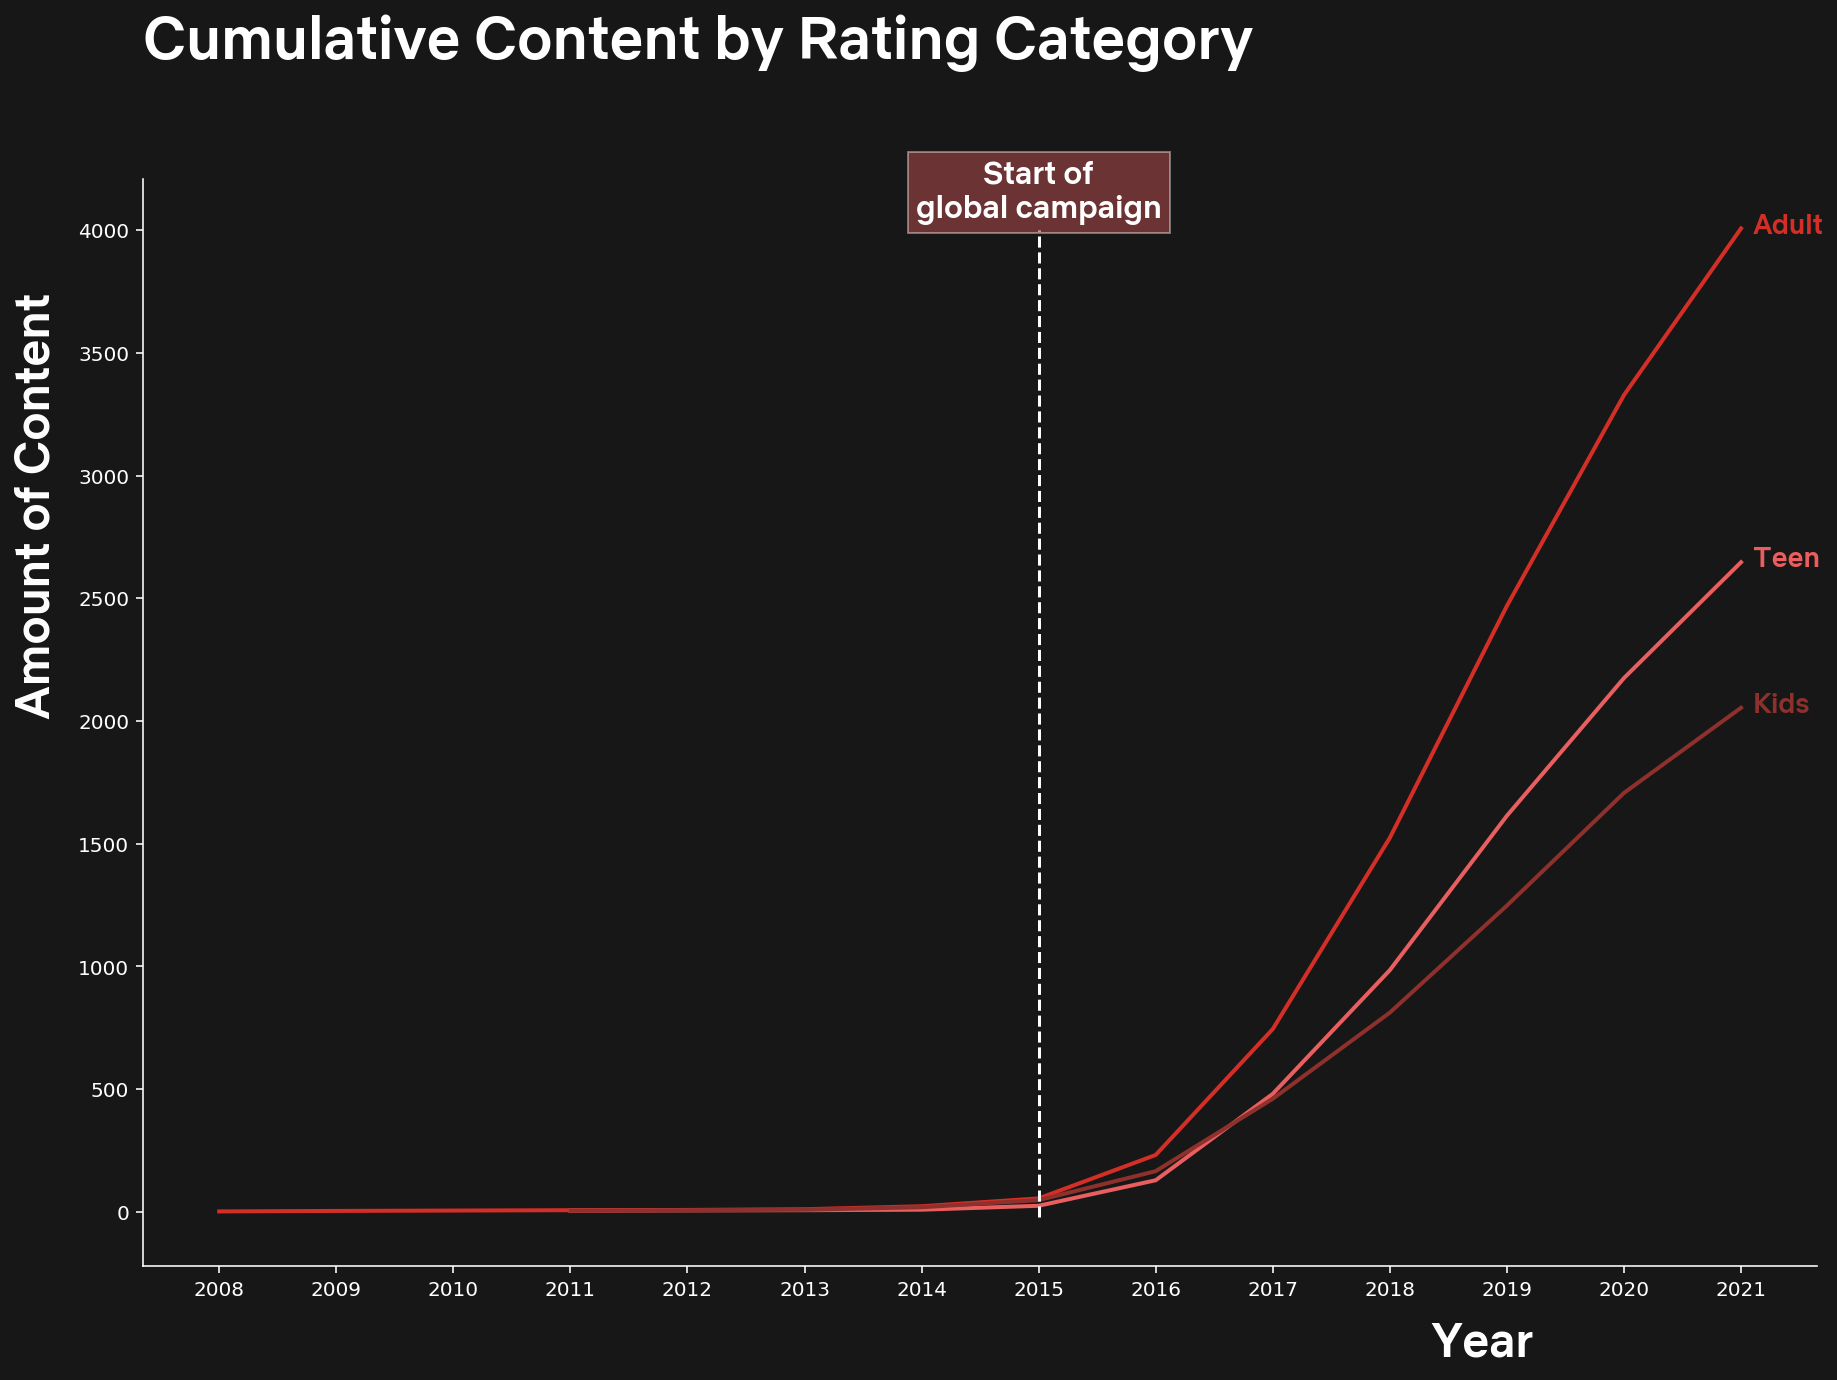

In [48]:
fig, ax = plt.subplots(figsize=(15,10))

rating_options = [adult_content, teen_content, kids_content]

rating_types = ['Adult', 'Teen', 'Kids']

rating_colors = ['#D32F27', '#E95E5F', '#8E302C']

ax.plot(adult_content, c=rating_colors[0], label='Adult', lw=2)
ax.plot(teen_content, c=rating_colors[1], label='Teen', lw=2)
ax.plot(kids_content, c=rating_colors[2], label='Kids', lw=2)

for i in range(len(rating_types)):
    ax.text(2021.1, rating_options[i].loc[2021.0]+10, s=rating_types[i], verticalalignment='center', horizontalalignment='left',
        color=rating_colors[i], fontdict=dict(fontsize=14, weight='bold', font='Netflix Sans'))

ax.set_title('Cumulative Content by Rating Category', fontdict=dict(fontsize=30, weight='bold', font='Netflix Sans'), x=0, y=1.1, horizontalalignment='left', color='white')
ax.set_xlabel('Year', fontdict=dict(fontsize=24, weight='bold', font='Netflix Sans', color='white'))
ax.set_ylabel('Amount of Content', fontdict=dict(fontsize=24, weight='bold', font='Netflix Sans', color='white'))
ax.xaxis.set_label_coords(0.8, -0.05)
ax.yaxis.set_label_coords(-0.05, 0.7)

'''ax.text(2021.1, 1460, 'International TV\naveraged 224 shows\nper year from 2016-2021', bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.2),
        verticalalignment='center', horizontalalignment='left', color='white')
ax.text(2021.1, 1100, "International ~ 51%\n\nDrama ~ 29%\n\nComedy ~ 22%\n\nof total TV content in '21", bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.2),
        verticalalignment='center', horizontalalignment='left', color='white')
ax.text(2007.40, 1675, "(By TV Show Category)", fontdict=dict(fontsize=22, weight='bold', font='Netflix Sans', 
                                                           horizontalalignment='left', verticalalignment='center', color='#E95E5F'))'''

ax.set_xticks(np.arange(2008, 2022), [str(i) for i in np.arange(2008, 2022)])

ax.vlines(2015, ymin=-20, ymax=4000, colors='#ffffff',
          linestyles='dashed')

# Global Campaign Text Box
ax.text(2015, 4050, s='Start of\nglobal campaign', 
        bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.4),
        horizontalalignment='center', fontdict=dict(fontsize=16, weight='bold', font='Netflix Sans', color='white'))

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor('#181717')
fig.set_facecolor('#181717')

plt.show()

In [50]:
all_ratings = netflix_df.groupby(['year_added', 'rating', 'type'])['show_id'].count().copy()
all_ratings = all_ratings.reset_index('rating')
all_ratings = clean_ratings(all_ratings, 'rating')

movie_ratings = all_ratings.loc[all_ratings.index.get_level_values('type')=='Movie'].copy()
movie_ratings = movie_ratings.droplevel(1)
print(movie_ratings)

tv_ratings = all_ratings.loc[all_ratings.index.get_level_values('type')=='TV Show'].copy()
tv_ratings = tv_ratings.droplevel(1)
print(tv_ratings)

           rating  show_id
year_added                
2008.0      TV-MA        1
2009.0      TV-MA        2
2010.0         NR        1
2011.0      TV-14        5
2011.0      TV-MA        3
...           ...      ...
2021.0       TV-G       20
2021.0      TV-MA      256
2021.0      TV-PG       58
2021.0       TV-Y       16
2021.0      TV-Y7       45

[104 rows x 2 columns]
              rating  show_id
year_added                   
2008.0         TV-MA        1
2013.0            NR        1
2013.0         TV-14        2
2013.0         TV-MA        2
2014.0          TV-G        1
2014.0         TV-MA        3
2014.0         TV-PG        1
2015.0         TV-14        5
2015.0          TV-G        2
2015.0         TV-MA        5
2015.0         TV-PG        6
2015.0          TV-Y        4
2015.0         TV-Y7        3
2015.0      TV-Y7-FV        1
2016.0             R        1
2016.0         TV-14       58
2016.0          TV-G        7
2016.0         TV-MA       48
2016.0         TV-PG     

/var/folders/sl/hgpfrzbj4kbbg6s9x7hc9f_h0000gn/T/ipykernel_97318/2533305070.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.upper()


In [51]:
adult_movies = movie_ratings.loc[movie_ratings['rating'].isin(adult_ratings)]
adult_movies = adult_movies.drop('rating', axis=1)
adult_movies = adult_movies.groupby(adult_movies.index).sum()
adult_movies = adult_movies.cumsum()

teen_movies = movie_ratings.loc[movie_ratings['rating'].isin(teen_ratings)]
teen_movies = teen_movies.drop('rating', axis=1)
teen_movies = teen_movies.groupby(teen_movies.index).sum()
teen_movies = teen_movies.cumsum()

kids_movies = movie_ratings.loc[movie_ratings['rating'].isin(kids_ratings)]
kids_movies = kids_movies.drop('rating', axis=1)
kids_movies = kids_movies.groupby(kids_movies.index).sum()
kids_movies = kids_movies.cumsum()




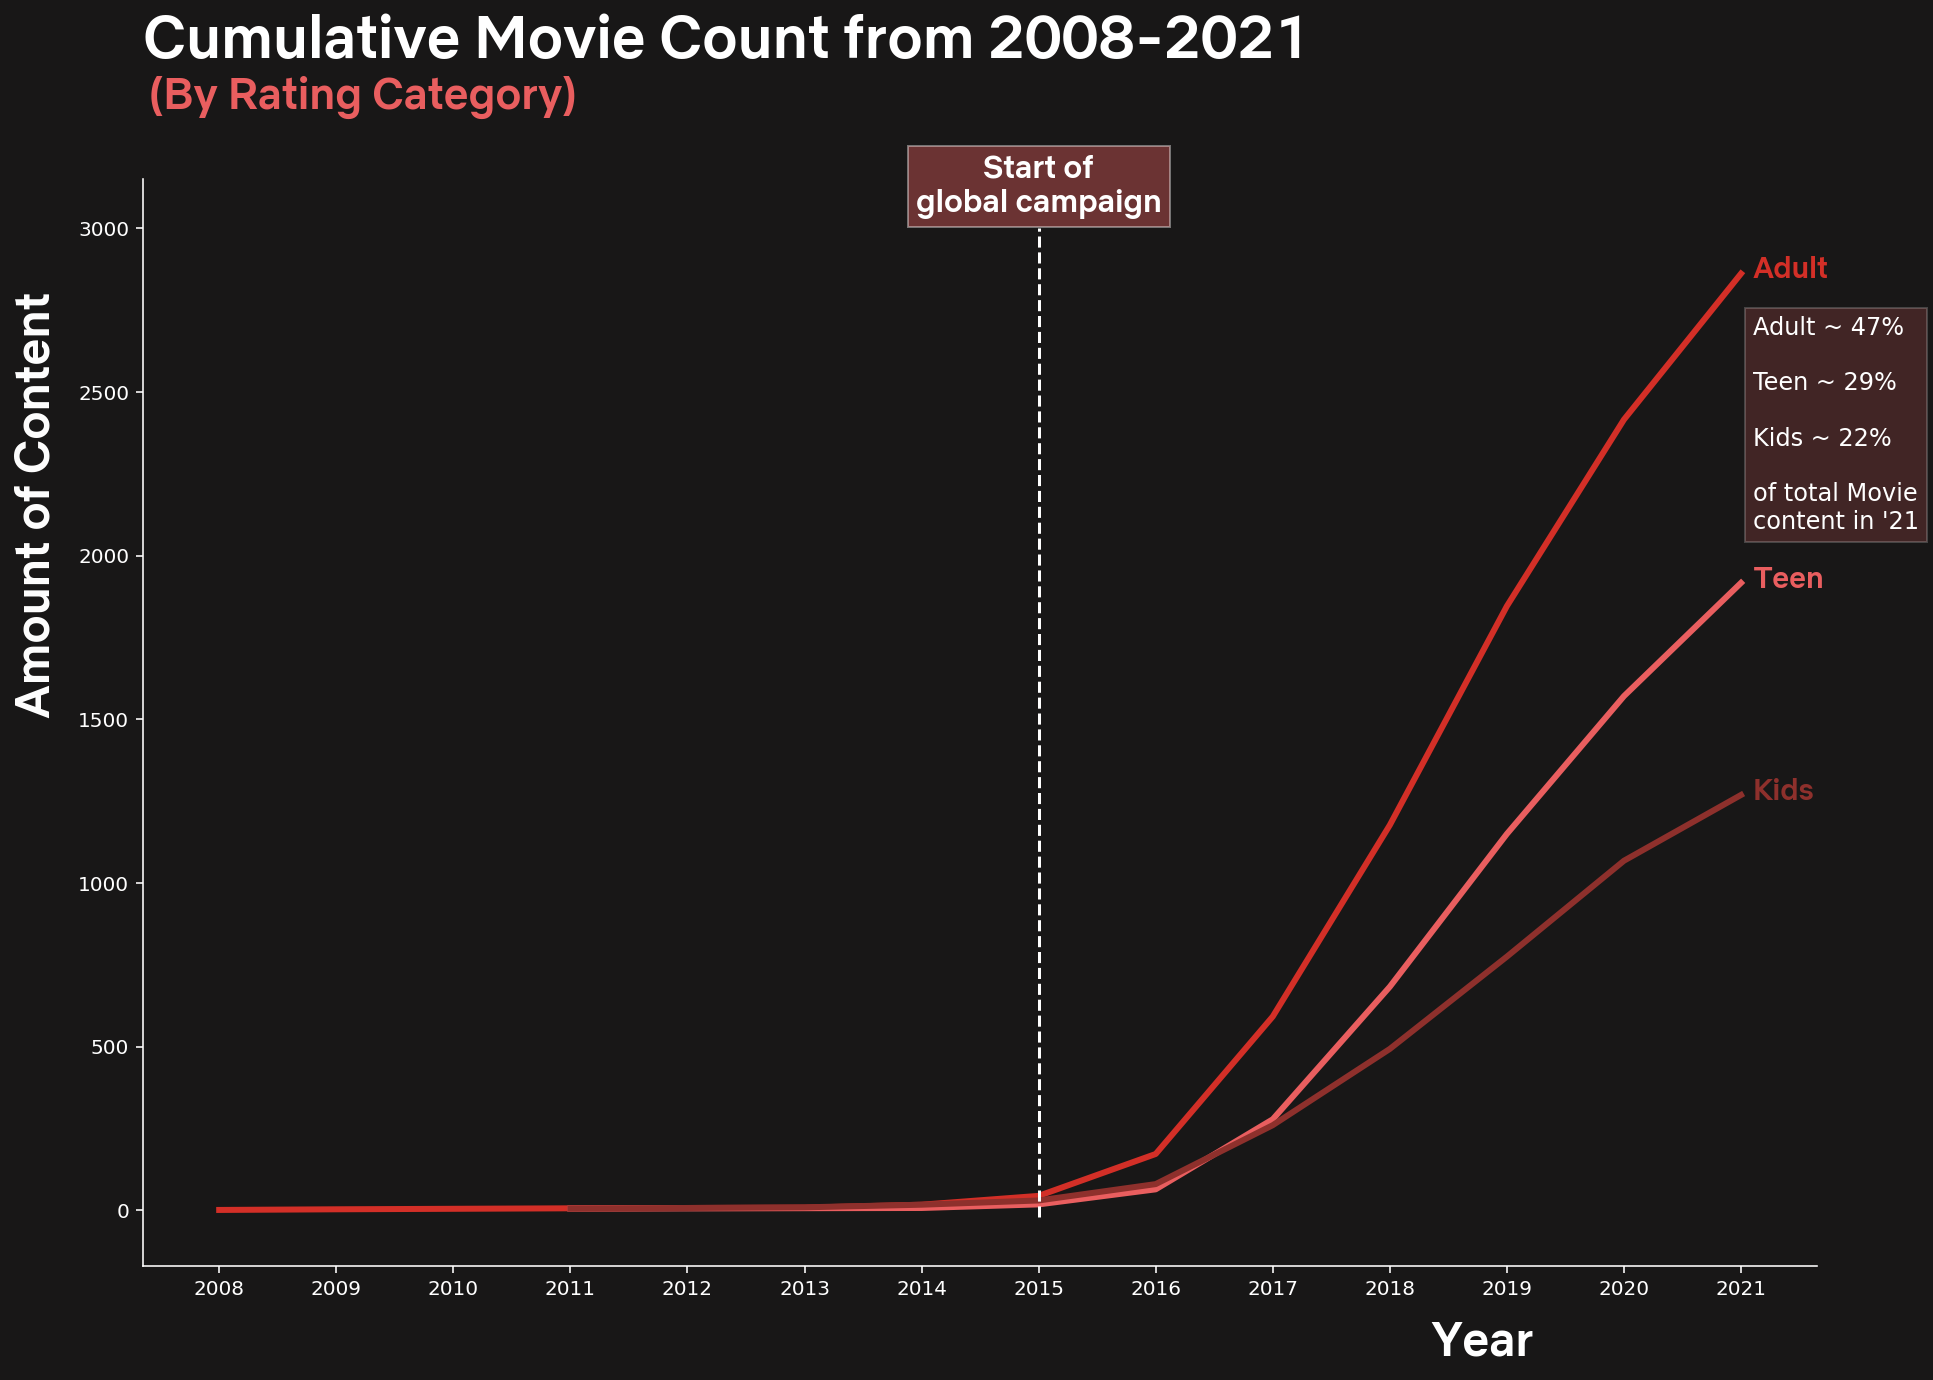

In [84]:
fig, ax = plt.subplots(figsize=(15,10))

rating_options = [adult_movies, teen_movies, kids_movies]

rating_types = ['Adult', 'Teen', 'Kids']

rating_colors = ['#D32F27', '#E95E5F', '#8E302C']


ax.plot(adult_movies, c=rating_colors[0], label='Adult', lw=3)
ax.plot(teen_movies, c=rating_colors[1], label='Teen', lw=3)
ax.plot(kids_movies, c=rating_colors[2], label='Kids', lw=3)

for i in range(len(rating_types)):
    ax.text(2021.1, rating_options[i].loc[2021.0]+10, s=rating_types[i], verticalalignment='center', horizontalalignment='left',
        color=rating_colors[i], fontdict=dict(fontsize=15, weight='bold', font='Netflix Sans'))

ax.set_title('Cumulative Movie Count from 2008-2021', fontdict=dict(fontsize=30, weight='bold', font='Netflix Sans'), x=0, y=1.1, horizontalalignment='left', color='white')
ax.set_xlabel('Year', fontdict=dict(fontsize=24, weight='bold', font='Netflix Sans', color='white'))
ax.set_ylabel('Amount of Content', fontdict=dict(fontsize=24, weight='bold', font='Netflix Sans', color='white'))
ax.xaxis.set_label_coords(0.8, -0.05)
ax.yaxis.set_label_coords(-0.05, 0.7)

ax.text(2021.1, 2400, "Adult ~ 47%\n\nTeen ~ 29%\n\nKids ~ 22%\n\nof total Movie\ncontent in '21", bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.2),
        verticalalignment='center', horizontalalignment='left', color='white', fontsize=12)
ax.text(2007.40, 3400, "(By Rating Category)", fontdict=dict(fontsize=22, weight='bold', font='Netflix Sans', 
                                                            horizontalalignment='left', verticalalignment='center', color='#E95E5F'))

ax.set_xticks(np.arange(2008, 2022), [str(i) for i in np.arange(2008, 2022)])

ax.vlines(2015, ymin=-20, ymax=3000, colors='#ffffff',
          linestyles='dashed')

# Global Campaign Text Box
ax.text(2015, 3050, s='Start of\nglobal campaign', 
        bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.4),
        horizontalalignment='center', fontdict=dict(fontsize=16, weight='bold', font='Netflix Sans', color='white'))

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor('#181717')
fig.set_facecolor('#181717')

plt.savefig('Movie_Ratings.pdf')
plt.show()

In [53]:
print(cumulative_movies.loc[2021.])
print(adult_movies.loc[2021].values/cumulative_movies.loc[2021., 'title'])
print(teen_movies.loc[2021].values/cumulative_movies.loc[2021, 'title'])
print(kids_movies.loc[2021].values/cumulative_movies.loc[2021, 'title'])

title         6131.000000
Proportion      10.618747
Name: 2021.0, dtype: float64
[0.46680802]
[0.3126733]
[0.20698092]


In [54]:
adult_tv = tv_ratings.loc[tv_ratings['rating'].isin(adult_ratings)]
adult_tv = adult_tv.drop('rating', axis=1)
adult_tv = adult_tv.groupby(adult_tv.index).sum()
adult_tv = adult_tv.cumsum()

teen_tv = tv_ratings.loc[tv_ratings['rating'].isin(teen_ratings)]
teen_tv = teen_tv.drop('rating', axis=1)
teen_tv = teen_tv.groupby(teen_tv.index).sum()
teen_tv = teen_tv.cumsum()

kids_tv = tv_ratings.loc[tv_ratings['rating'].isin(kids_ratings)]
kids_tv = kids_tv.drop('rating', axis=1)
kids_tv = kids_tv.groupby(kids_tv.index).sum()
kids_tv = kids_tv.cumsum()

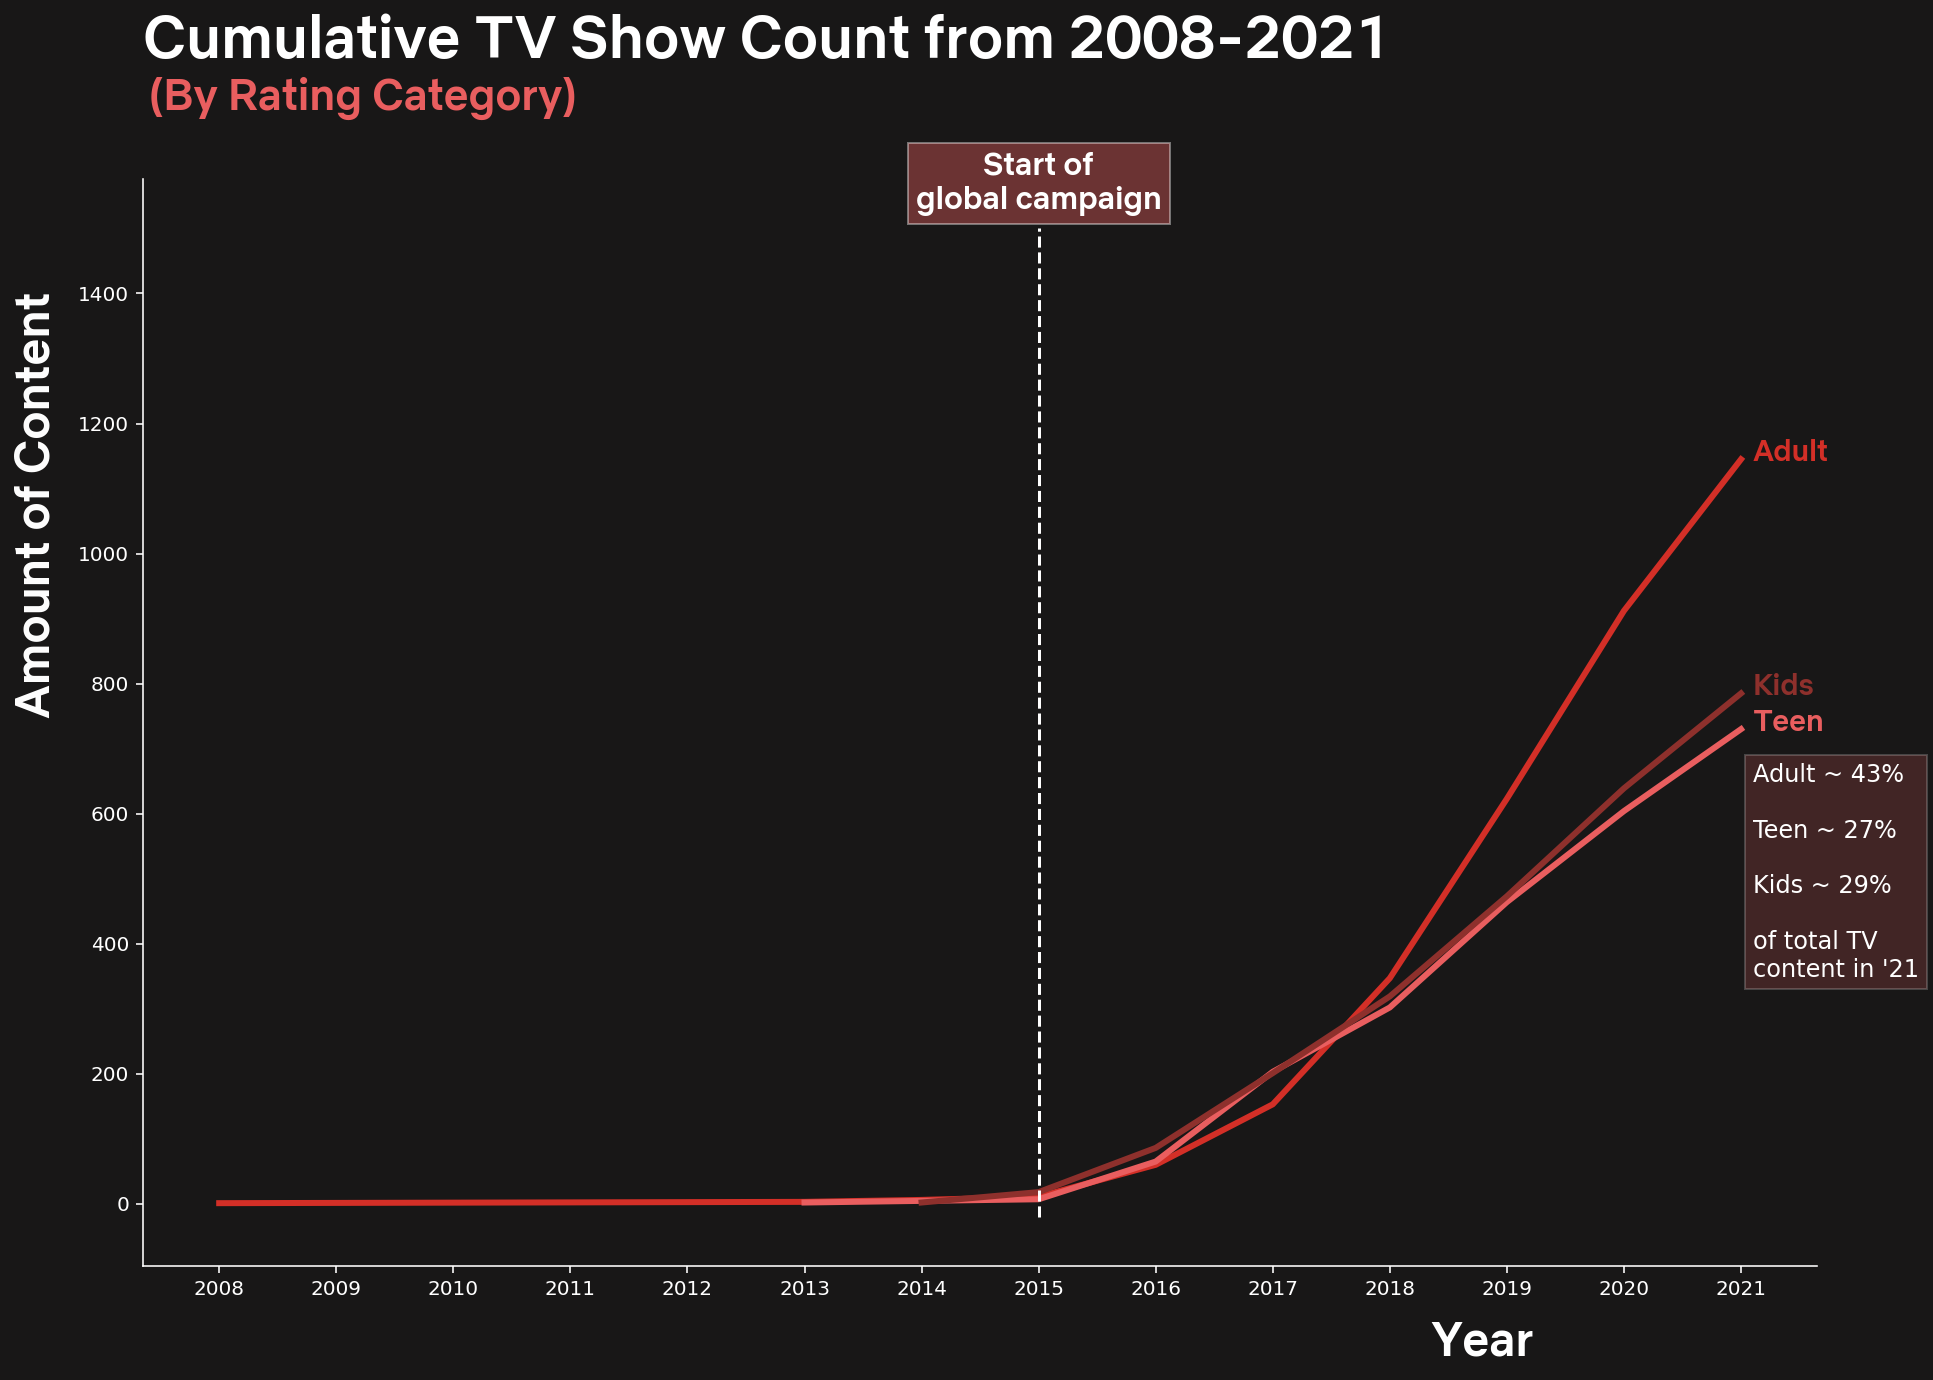

In [83]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(adult_tv, c=rating_colors[0], label='Adult', lw=3)
ax.plot(teen_tv, c=rating_colors[1], label='Teen', lw=3)
ax.plot(kids_tv, c=rating_colors[2], label='Kids', lw=3)

rating_options = [adult_tv, teen_tv, kids_tv]

rating_types = ['Adult', 'Teen', 'Kids']

rating_colors = ['#D32F27', '#E95E5F', '#8E302C']


for i in range(len(rating_types)):
    ax.text(2021.1, rating_options[i].loc[2021.0]+10, s=rating_types[i], verticalalignment='center', horizontalalignment='left',
        color=rating_colors[i], fontdict=dict(fontsize=15, weight='bold', font='Netflix Sans'))

ax.set_title('Cumulative TV Show Count from 2008-2021', fontdict=dict(fontsize=30, weight='bold', font='Netflix Sans'), x=0, y=1.1, horizontalalignment='left', color='white')
ax.set_xlabel('Year', fontdict=dict(fontsize=24, weight='bold', font='Netflix Sans', color='white'))
ax.set_ylabel('Amount of Content', fontdict=dict(fontsize=24, weight='bold', font='Netflix Sans', color='white'))
ax.xaxis.set_label_coords(0.8, -0.05)
ax.yaxis.set_label_coords(-0.05, 0.7)

ax.text(2021.1, 510, "Adult ~ 43%\n\nTeen ~ 27%\n\nKids ~ 29%\n\nof total TV\ncontent in '21", bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.2),
        verticalalignment='center', horizontalalignment='left', color='white', fontsize=12)
ax.text(2007.40, 1700, "(By Rating Category)", fontdict=dict(fontsize=22, weight='bold', font='Netflix Sans', 
                                                            horizontalalignment='left', verticalalignment='center', color='#E95E5F'))

ax.set_xticks(np.arange(2008, 2022), [str(i) for i in np.arange(2008, 2022)])

ax.vlines(2015, ymin=-20, ymax=1500, colors='#ffffff',
          linestyles='dashed')

# Global Campaign Text Box
ax.text(2015, 1530, s='Start of\nglobal campaign', 
        bbox=dict(facecolor='#E95E5F', edgecolor='white', alpha=0.4),
        horizontalalignment='center', fontdict=dict(fontsize=16, weight='bold', font='Netflix Sans', color='white'))

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor('#181717')
fig.set_facecolor('#181717')

plt.savefig('TV_ratings.pdf')
plt.show()

In [56]:
print(cumulative_tv.loc[2021.])
print(adult_tv.loc[2021].values/cumulative_tv.loc[2021., 'title'])
print(teen_tv.loc[2021].values/cumulative_tv.loc[2021, 'title'])
print(kids_tv.loc[2021].values/cumulative_tv.loc[2021, 'title'])

title         2666.000000
Proportion       3.381253
Name: 2021.0, dtype: float64
[0.42948237]
[0.27381845]
[0.29444861]


In [57]:
print(netflix_df['release_year'].unique())

[2020 2021 1993 2018 1996 1998 1997 2010 2013 2017 1975 1978 1983 1987
 2012 2001 2014 2002 2003 2004 2011 2008 2009 2007 2005 2006 1994 2015
 2019 2016 1982 1989 1990 1991 1999 1986 1992 1984 1980 1961 2000 1995
 1985 1976 1959 1988 1981 1972 1964 1945 1954 1979 1958 1956 1963 1970
 1973 1925 1974 1960 1966 1971 1962 1969 1977 1967 1968 1965 1946 1942
 1955 1944 1947 1943]


In [58]:
print(netflix_df['countries'].unique())

['united states' 'south africa' nan 'india'
 'united states, ghana, burkina faso, united kingdom, germany, ethiopia'
 'united kingdom' 'germany, czech republic' 'mexico' 'turkey' 'australia'
 'united states, india, france' 'finland' 'china, canada, united states'
 'south africa, united states, japan' 'nigeria' 'japan'
 'spain, united states' 'france' 'belgium' 'united kingdom, united states'
 'united states, united kingdom' 'france, united states' 'south korea'
 'spain' 'united states, singapore' 'united kingdom, australia, france'
 'united kingdom, australia, france, united states'
 'united states, canada' 'germany, united states'
 'south africa, united states' 'united states, mexico'
 'united states, italy, france, japan'
 'united states, italy, romania, united kingdom'
 'australia, united states' 'argentina, venezuela'
 'united states, united kingdom, canada' 'china, hong kong' 'russia'
 'canada' 'hong kong' 'united states, china, hong kong'
 'italy, united states' 'united states, g

In [59]:
country_df = netflix_df.copy()

#print(country_df.info())
#country_df['countries'] = country_df['countries'].str.split(',')
country_df['countries'] = country_df['countries'].replace(np.nan, 'Missing')
#print(country_df['countries'].unique())

country_df['year_added'] = country_df['year_added'].replace(np.nan, 'Missing')
years = country_df['year_added'].unique()

year_dict = {}
for i in range(len(country_df['countries'])):
	year_added = country_df.loc[i, 'year_added']
	countries = country_df.loc[i, 'countries']
	if year_added == 'Missing' or not countries:
		continue
	year_added = int(year_added)
	if year_added in year_dict.keys():
		countries = set(countries.strip().split(', '))
		year_dict[year_added] = year_dict[year_added].union(countries)
	else:
		year_dict[year_added] = set()
		countries = set(countries.strip().split(', '))
		year_dict[year_added] = year_dict[year_added].union(countries)

yr_vals = sorted(year_dict.keys())
print(yr_vals)

country_counts = list()
for yr in yr_vals:
	if 'Missing' in year_dict[yr]:
		year_dict[yr].remove('Missing')
	if '' in year_dict[yr]:
		year_dict[yr].remove('')
	country_counts.append(len(year_dict[yr]))

print(country_counts)


[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
[1, 2, 1, 5, 2, 4, 10, 16, 52, 77, 83, 73, 76, 72]


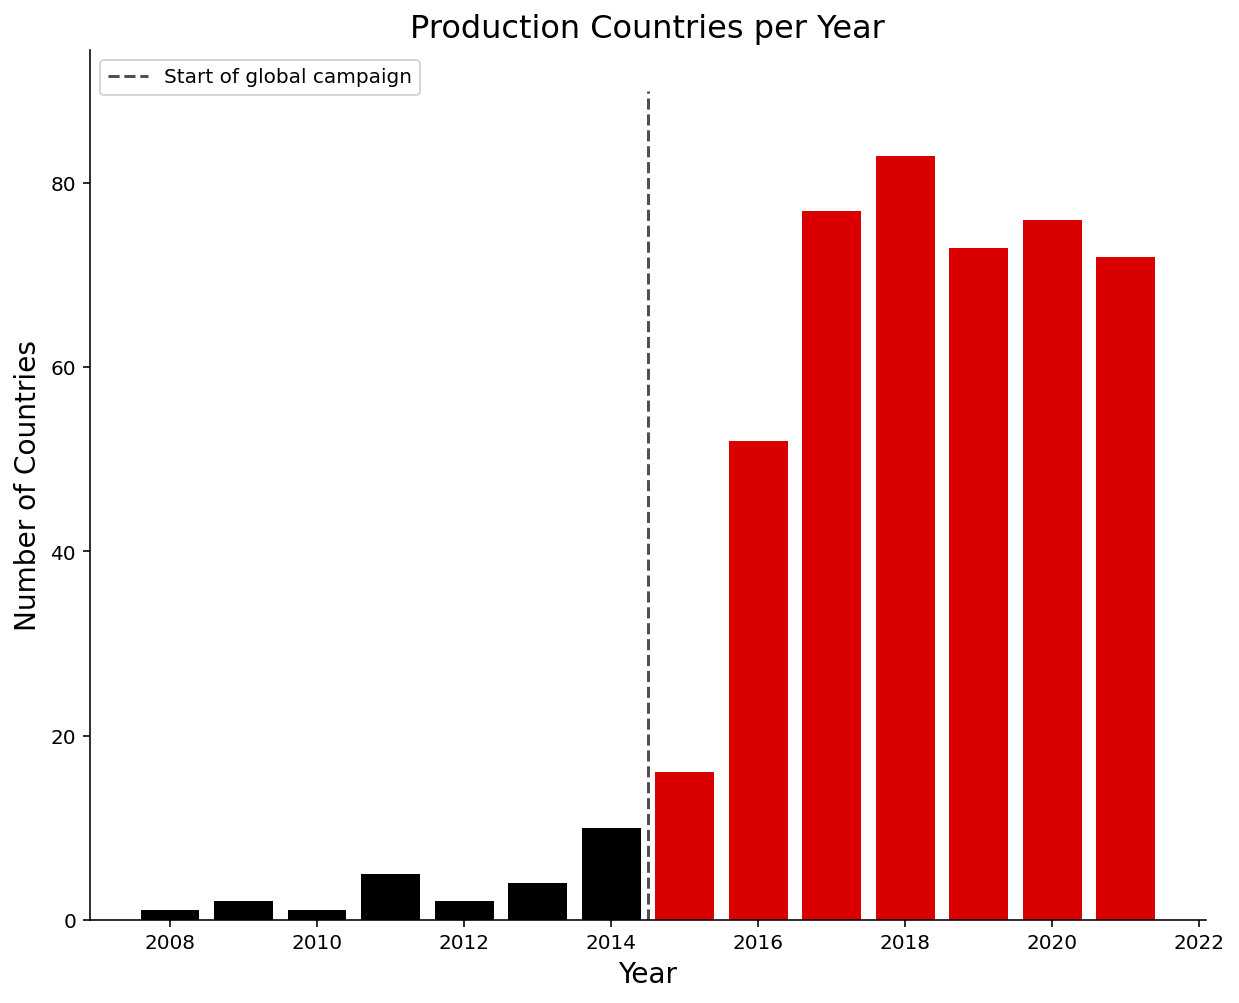

In [60]:
fig, ax = plt.subplots(figsize=(10,8))

colors = np.repeat(np.array(['#000000', '#db0000']), [7,7])

ax.bar(yr_vals, country_counts, color=colors)

ax.set_xlabel('Year', size=14)
ax.set_ylabel('Number of Countries', size=14)
ax.set_title('Production Countries per Year', size=16)

ax.vlines(2014.5, ymin=0, ymax=90, colors='#564d4d',
          linestyles='dashed', label='Start of global campaign')

plt.legend(loc='upper left')

ax.spines[['top', 'right']].set_visible(False)

plt.show()

In [61]:
month_data = netflix_df.groupby('month_added').count()
month_data = month_data.drop('Missing', axis=0)
month_data = month_data.reindex(['January', 'February', 'March', 'April',
                                 'May', 'June', 'July', 'August', 'September',
                                 'October', 'November', 'December'])
print(month_data)

             show_id  type  title  director  cast  country  date_added  \
month_added                                                              
January          738   738    738       537   681      701         738   
February         563   563    563       385   506      541         563   
March            742   742    742       542   672      686         742   
April            764   764    764       549   684      694         764   
May              632   632    632       446   570      545         632   
June             728   728    728       495   656      633         728   
July             827   827    827       577   747      708         827   
August           755   755    755       530   677      667         755   
September        770   770    770       520   683      661         770   
October          760   760    760       546   691      701         760   
November         705   705    705       497   656      671         705   
December         813   813    813     

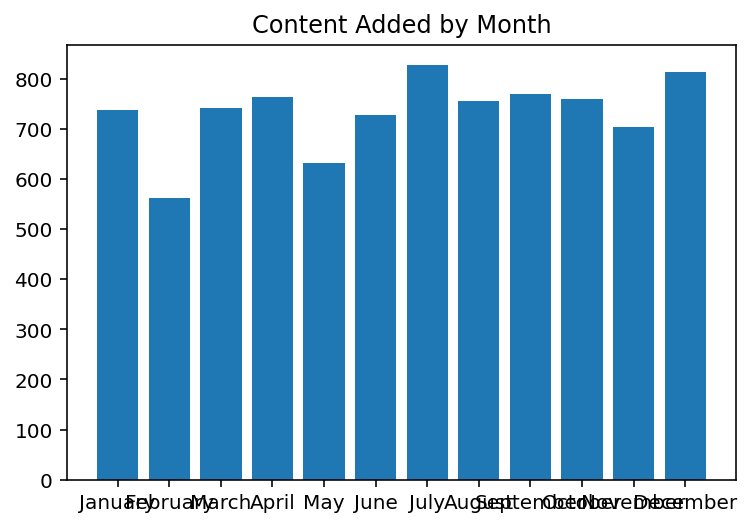

In [62]:
fig, ax = plt.subplots(figsize=(6,4))

ax.bar(month_data.index, month_data['show_id'])

ax.set_title('Content Added by Month')
plt.show()

In [63]:
month_data = netflix_df.groupby(['month_added', 'type']).count()['show_id']
month_data = month_data.drop('Missing', axis=0)
movies_months = month_data[month_data.index.get_level_values('type')=='Movie']
tv_months = month_data[month_data.index.get_level_values('type')=='TV Show']

movies_months = movies_months.droplevel(1)
tv_months = tv_months.droplevel(1)

movies_months = movies_months.reindex(['January', 'February', 'March', 'April',
                                 'May', 'June', 'July', 'August', 'September',
                                 'October', 'November', 'December'])

tv_months = tv_months.reindex(['January', 'February', 'March', 'April',
                                 'May', 'June', 'July', 'August', 'September',
                                 'October', 'November', 'December'])

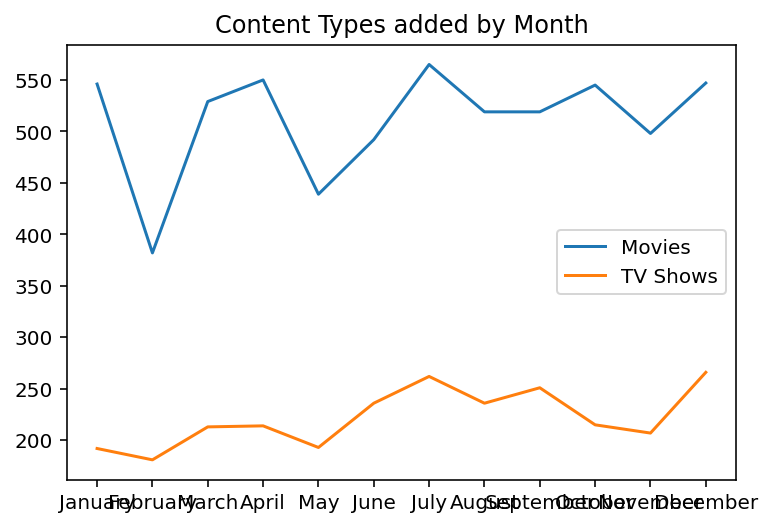

In [64]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(movies_months.index, movies_months, label='Movies')
ax.plot(tv_months.index, tv_months, label='TV Shows')

ax.set_title('Content Types added by Month')

plt.legend()

plt.show()

In [65]:
df_2020 = netflix_df[netflix_df['year_added']==2020.].copy()
tab = pd.crosstab(index=netflix_df['type'], columns='percentage', normalize='columns')
print(tab)


col_0    percentage
type               
Movie      0.696151
TV Show    0.303849


In [66]:
final_month = netflix_df.groupby(['month_added', 'year_added', 'type']).count()['show_id']
print(final_month)

month_added  year_added  type   
April        2014.0      Movie        1
                         TV Show      1
             2015.0      Movie        1
                         TV Show      4
             2016.0      Movie       14
                                   ... 
September    2019.0      TV Show     37
             2020.0      Movie      115
                         TV Show     53
             2021.0      Movie      118
                         TV Show     65
Name: show_id, Length: 193, dtype: int64


In [67]:
fin_month = final_month.copy()
fin_month = fin_month.to_frame()

fin_month.reset_index('year_added', inplace=True)

# pull out type by month data for years after 2015
post_months_df = fin_month.loc[fin_month['year_added'] >= 2015.0].copy()
post_months_df.rename({'show_id': 'Count'}, axis=1, inplace=True)
print(post_months_df)

                     year_added  Count
month_added type                      
April       Movie        2015.0      1
            TV Show      2015.0      4
            Movie        2016.0     14
            TV Show      2016.0      8
            Movie        2017.0     66
...                         ...    ...
September   TV Show      2019.0     37
            Movie        2020.0    115
            TV Show      2020.0     53
            Movie        2021.0    118
            TV Show      2021.0     65

[160 rows x 2 columns]


In [68]:
post_month_avgs = post_months_df.groupby(['month_added', 'type']).agg({'Count': ['mean', 'max']})

'''post_months_df = post_months_df.reindex(['January', 'February', 'March', 'April',
                        				'May', 'June', 'July', 'August', 'September',
                        				'October', 'November', 'December'])'''

post_movies = post_month_avgs[post_month_avgs.index.get_level_values('type')=='Movie']
post_movies = post_movies.droplevel(1)
post_movies.columns = post_movies.columns.droplevel(0)

post_tv = post_month_avgs[post_month_avgs.index.get_level_values('type')=='TV Show']
post_tv = post_tv.droplevel(1)
post_tv.columns = post_tv.columns.droplevel(0)

post_movies = post_movies.reindex(['January', 'February', 'March', 'April',
                                   'May', 'June', 'July', 'August', 'September',
                                   'October', 'November', 'December'])

post_tv = post_tv.reindex(['January', 'February', 'March', 'April',
                           'May', 'June', 'July', 'August', 'September',
                           'October', 'November', 'December'])

print(post_movies)
print(post_tv)

                  mean  max
month_added                
January      77.571429  152
February     54.285714  103
March        75.571429  138
April        78.428571  135
May          62.428571  105
June         70.142857  124
July         80.571429  169
August       74.000000  130
September    73.714286  118
October      88.166667  146
November     81.833333  187
December     89.833333  168
                  mean  max
month_added                
January      32.000000   53
February     25.571429   45
March        30.285714   53
April        30.428571   53
May          27.571429   52
June         33.714286   83
July         37.428571   88
August       39.166667   61
September    35.714286   65
October      35.500000   65
November     34.166667   68
December     44.166667   68


In [69]:
font = {'family' : 'Times',
        'color' : 'black',
        'weight': 'normal',
        'size': 16}

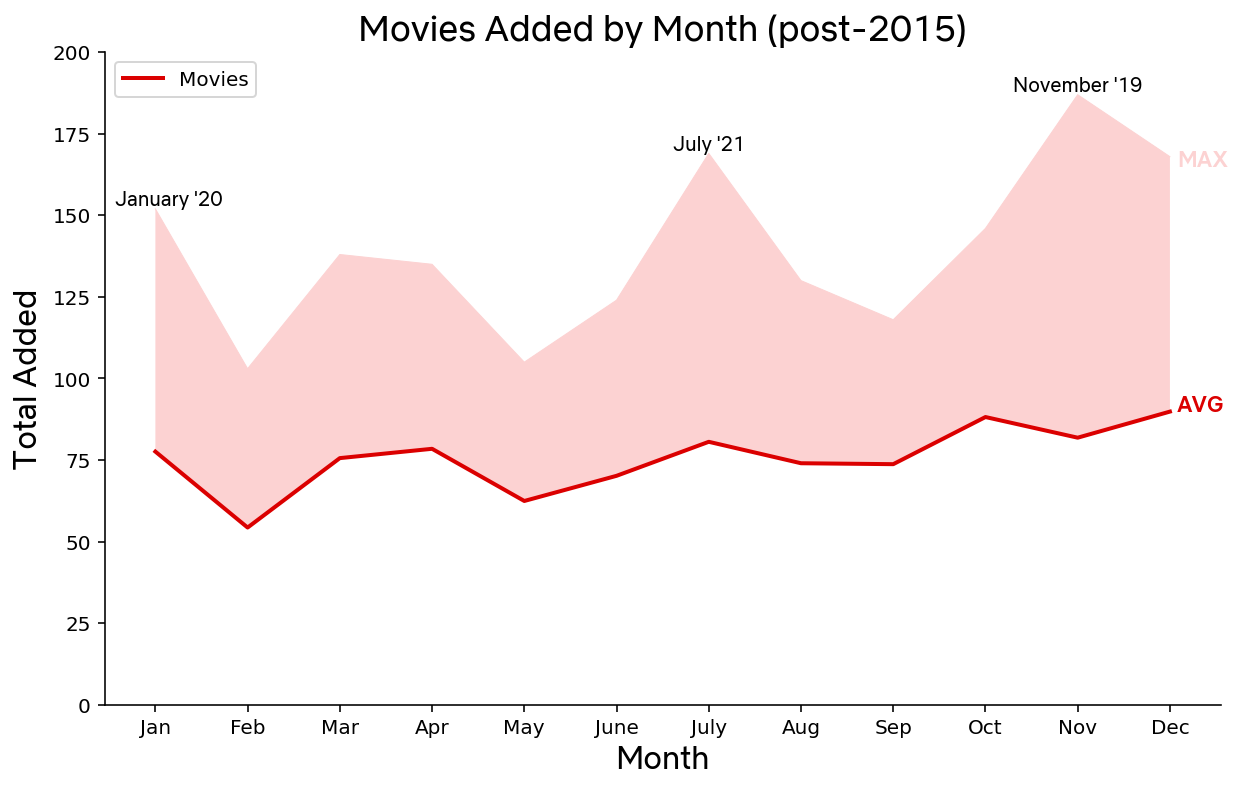

In [70]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(post_movies['mean'], color='#db0000', lw=2, label='Movies')
ax.plot(post_movies['max'], color='#fcd2d2', lw=0.5)
ax.fill_between(post_movies.index, post_movies['mean'], post_movies['max'],
                facecolor='#fcd2d2')

ax.set_xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June',
                              'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

ax.set_xlabel('Month', fontdict=dict(fontsize=16, font='Netflix Sans'))
ax.set_ylabel('Total Added', fontdict=dict(fontsize=16, font='Netflix Sans'))
ax.set_title('Movies Added by Month (post-2015)', fontdict=dict(fontsize=18, font='Netflix Sans'), size=18)

ax.set_ybound(0, 200)

ax.text(0.15, post_movies.loc['January', 'max'] + 1, s="January '20",fontdict=dict(fontsize=10, font='Netflix Sans'),
        horizontalalignment='center')

ax.text(6, post_movies.loc['July', 'max'] + 1, s="July '21",fontdict=dict(fontsize=10, font='Netflix Sans'),
        horizontalalignment='center')

ax.text(10, post_movies.loc['November', 'max'] + 1, s="November '19",fontdict=dict(fontsize=10, font='Netflix Sans'),
        horizontalalignment='center')

ax.text(11.075, 165, s='MAX',
        horizontalalignment='left', fontdict=dict(fontsize=11, font='Netflix Sans'), c='#fcd2d2',
        weight='bold')

ax.text(11.075, 90, s='AVG',
        horizontalalignment='left', fontdict=dict(fontsize=11, font='Netflix Sans'), c='#db0000',
        weight='bold')

ax.spines[['top', 'right']].set_visible(False)

plt.legend()
plt.show()

In [71]:
# print(post_months_df[post_months_df.index.get_level_values('month_added')=='July'])
print(post_months_df[post_months_df.index.get_level_values('month_added')=='November'])

                     year_added  Count
month_added type                      
November    Movie        2015.0      2
            TV Show      2015.0      2
            Movie        2016.0     26
            TV Show      2016.0     18
            Movie        2017.0     55
            TV Show      2017.0     30
            Movie        2018.0    118
            TV Show      2018.0     36
            Movie        2019.0    187
            TV Show      2019.0     68
            Movie        2020.0    103
            TV Show      2020.0     51


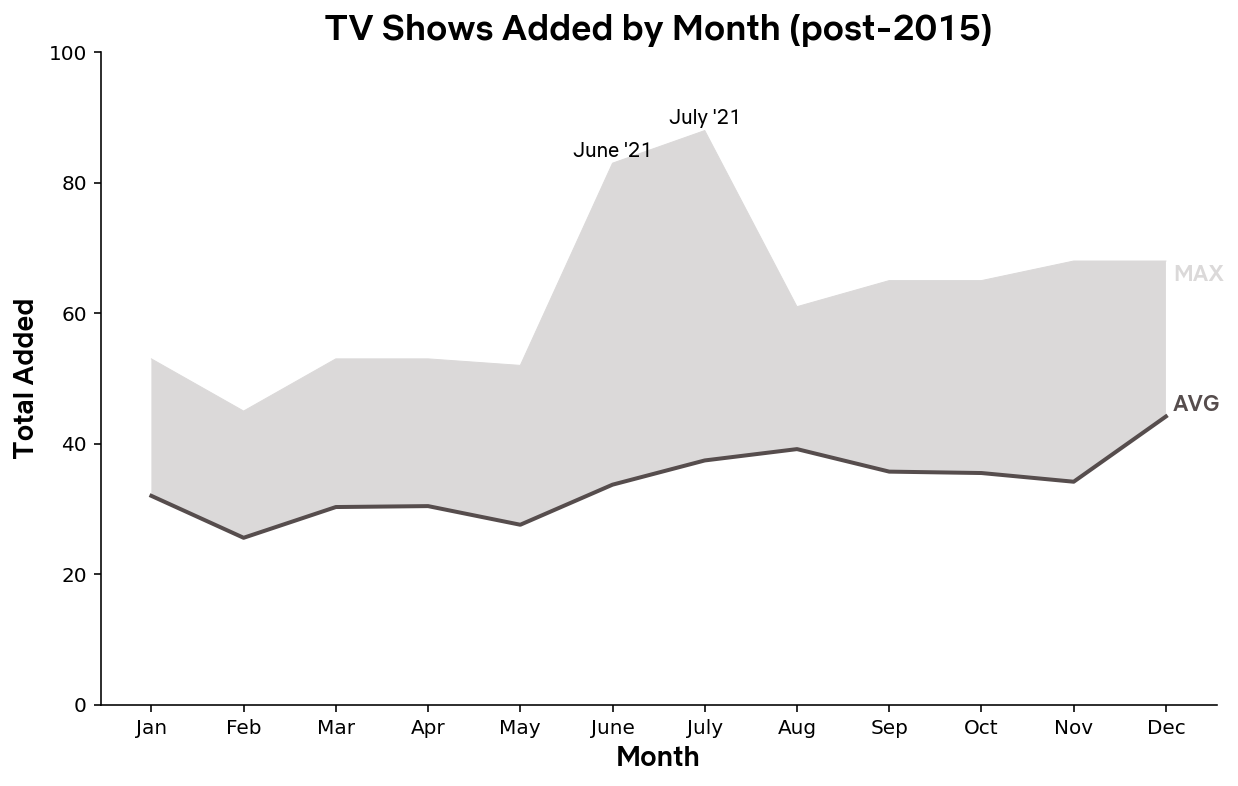

In [72]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(post_tv['mean'], color='#564d4d', lw=2, label='TV Show')
ax.plot(post_tv['max'], color='#dbd9d9', lw=0.5)
ax.fill_between(post_tv.index, post_tv['mean'], post_tv['max'],
                facecolor='#dbd9d9')

ax.set_xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June',
                              'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

ax.set_xlabel('Month', fontdict=dict(fontsize=14, weight='bold', font='Netflix Sans'))
ax.set_ylabel('Total Added', fontdict=dict(fontsize=14, weight='bold', font='Netflix Sans'))
ax.set_title('TV Shows Added by Month (post-2015)', fontdict=dict(fontsize=18, weight='bold', font='Netflix Sans'))

ax.text(6, post_tv.loc['July','max'] + 1, s="July '21",fontdict=dict(fontsize=10, font='Netflix Sans'),
        horizontalalignment='center')

ax.text(5, post_tv.loc['June','max'] + 1, s="June '21",fontdict=dict(fontsize=10, font='Netflix Sans'),
        horizontalalignment='center')

ax.text(11.075, 65, s='MAX',
        horizontalalignment='left', fontsize=11, c='#dbd9d9',fontdict=dict(fontsize=14, weight='bold', font='Netflix Sans'),
        weight='bold')

ax.text(11.075, 45, s='AVG',
        horizontalalignment='left', fontsize=11, c='#564d4d',fontdict=dict(fontsize=14, weight='bold', font='Netflix Sans'),
        weight='bold')

ax.set_ybound(0, 100)

ax.spines[['top', 'right']].set_visible(False)

plt.show()

In [73]:
# print(post_months_df[post_months_df.index.get_level_values('month_added')=='July'])
print(post_months_df[post_months_df.index.get_level_values('month_added')=='June'])

                     year_added  Count
month_added type                      
June        Movie        2015.0      4
            TV Show      2015.0      2
            Movie        2016.0     11
            TV Show      2016.0      7
            Movie        2017.0     65
            TV Show      2017.0     29
            Movie        2018.0     50
            TV Show      2018.0     28
            Movie        2019.0    122
            TV Show      2019.0     46
            Movie        2020.0    115
            TV Show      2020.0     41
            Movie        2021.0    124
            TV Show      2021.0     83
